**Introduction:**

Using simple random search. In our case, the cost function is just the reach error -- calculated by the reach error between the previous lamdba values and the current one. 

Error is defined as reach error: $ error = ||t-y||^2 $ and the perturbation term $ p_{2k+1} $ can be thought of a normal distribution.

$$ FR+ = FR - \frac{\nu}{N\delta} \sum_{n = 1}^N ( error(FR + \delta p) - error(FR) ) \cdot  p, p \sim \mathcal{N}(0,\sigma^2) $$

Note: p is a perturbation taken from a distribution with mean = 0

References:

[1] G. Cauwenberghs, “A Fast Stochastic Error-Descent Algorithm for Supervised Learning and Optimization,” in Advances in Neural Information Processing Systems 5, S. J. Hanson, J. D. Cowan, and C. L. Giles, Eds. Morgan-Kaufmann, 1993, pp. 244–251.

[2] R. Héliot, K. Ganguly, J. Jimenez, and J. M. Carmena, “Learning in Closed-Loop Brain–Machine Interfaces: Modeling and Experimental Validation,” IEEE Transactions on Systems, Man, and Cybernetics, Part B (Cybernetics), vol. 40, no. 5, pp. 1387–1397, Oct. 2010, doi: 10.1109/TSMCB.2009.2036931.


__Test Cases:__

1. Try ideal scenario: KW = Identity matrix, A = 0, B = 0
2. Limit number of neurons to 2
3. Test SGD against simple cost function ($y = x^2$)
4. Ideal scenario with A/B: KW = I, A - Kb = 0

In [1]:
import numpy as np
from numpy import linalg
import numpy.matlib
import matplotlib.pyplot as plt
import seaborn

seaborn.set()


### Brain Modeling

In [2]:
# Brain Model 
###################
# Function that calculates firing rate from b, W, t
# B(t) = b + [Wx Wy][tx ty]' = firing rate
# This is Equation (2.a, 2.b) in Heliot et al, 2010

## INPUT
# N = number of neurons
# lambda_vect = [b, W_x, W_y] for each neuron; N x 3
# targ_vect = 2 x 1
## OUTPUT
# newFR = N x 1
def brainFiringRate(lambda_vect, targ_vect):
    targ_vect_mult = np.insert(targ_vect.copy(), 0, 1)
    newFR = np.zeros( (np.size(lambda_vect, 0), 1) )
    newFR[:, 0] = np.matmul(lambda_vect, targ_vect_mult)
    return newFR

#********
# Passed test:
# lambda_vect = np.array([[1, 2, 3], [4, 5, 6], [7,8,9], [10, 11, 12]])
# targ_vect = np.array([1, 2])
# brainFiringRate(lambda_vect, targ_vect) = b + Wt
#********


###################
# Function that alters the lambda paramters (b, W) for the brain
# B(t) = b + [Wx Wy][tx ty]' = firing rate
# This is Equation (6) in Heliot et al, 2010

## INPUT
# N = number of neurons
# lambda_vect = [b, W_x, W_y] for each neuron; N x 3
# delta_perturb = N x 1  
# targ_vect = 2 x 1
## MIDDLE
# targ_vect_mult = 3 x 1 [1 t_x t_y]'
# targ_matx = N x 3
# delta_matx = N x 3
# next_term = delta_matx*delta_matx (element-wise mult) = N x 3
## OUTPUT
# lambda_vect_new = N x 3

def calcNextLambda(lambda_vect, gamma, delta_perturb, targ_vect):
    # This is the vector to multiply the lambda update term with = [1 t_x t_y]'
    num_neurons = np.size(lambda_vect.copy(), 0)
    targ_vect_mult = np.insert(targ_vect.copy(), 0, 1) # 3 x 1  
    targ_matx = (np.matlib.repmat(targ_vect_mult, num_neurons, 1)) # N x 3

    # next gradient term: \gamma*delta_perturb
    delta_matx = np.matlib.repmat(delta_perturb, 1, 3) # N x 3
    next_term = (delta_matx*targ_matx) # 3 x N
    lambda_vect_new = lambda_vect.copy() - (gamma*next_term)
    return lambda_vect_new

#********
# Passed test:
# lambda_vect = np.array([[1, 2, 3], [4, 5, 6], [7,8,9], [10, 11, 12]])
# targ_vect = np.array([1, 2])
# gamma = 0.5
# delta_perturb = np.array([[4], [5], [6], [7]])
# calcNextLambda(lambda_vect, gamma, delta_perturb, targ_vect) = lambda_vect - (gamma*error grad*[1 tx ty])
#********

### Decoder Model

In [3]:
####################
# Decoder Model 
# Affine Function that calculates target postion from firing rate
# Y = D(f) = a + Kf --> Weiner Filter
# This is Equation (1) in Heliot et al, 2010

## INPUT
# N = number of neurons, d = dimension of target
# decoder params = current a vector and K matrix (a = d x 1, K = d x N)
# fr_curr = current firing rate as a vector
# targ_vect = target position (T_x, Y_y)
## OUTPUT
# Cursor position = Y_x, Y_y
def decoder_findY(decoder_params, brain_params):
    # check firing rate 
    # Start with affine decoder
    (a_vect_in, k_matx_in) = decoder_params
    (fr_curr, targ) = brain_params
    a_vect = a_vect_in.copy()
    k_matx = k_matx_in.copy()
    cursor_pos = np.zeros( (NUM_DIM, 1))
    cursor_pos = a_vect.reshape(NUM_DIM, 1) +  (np.matmul(k_matx, fr_curr))
    return (cursor_pos)

#********
# Passed Test: 
# a = np.array([-10, -20])
# k = np.random.random([2, 4])
# NUM_DIM = 2
# fr = brainFiringRate(lambda_vect, targ_vect)
# decoder_params = (a, k)
# brain_params = (fr, targ_vect)
# pos = decoder_findY(decoder_params, brain_params) = a + Kf
#********

ADAPT_DEC = True

# Function uses stochastic gradient descent to adjust decoder parameters
## INPUT
# decoder params = current a vector and K matrix (a = d x 1, K = d x N)
# fr_curr = current firing rate as a vector
## OUTPUT
# next decoder parameters = a_next, k_next
def calcNextDecoder(decoder_params, brain_vars):
    (a_vect, a_rate, a_dist, k_matx, k_rate, k_dist) = decoder_params
    cost_func_args = ( (a_vect, k_matx), brain_vars)
    # a vector
    if (ADAPT_DEC == True):
        a_grad = findErrorGrad(a_vect.copy(), A_VAR, a_dist, error_costFunc, cost_func_args)
        k_grad = findErrorGrad(k_matx.copy(), K_VAR, k_dist, error_costFunc, cost_func_args)
        a_next = a_vect.copy().reshape(np.shape(a_grad)) - a_rate*a_grad
        k_next = k_matx.copy() - k_rate*k_grad
    else:
        a_next = a_vect
        k_next = k_matx

    return (a_next, k_next)

#*******
# TODO: Test this function
#*******

### Reach Error

In [4]:
####################
# Reach error
# This is Equation (3) in Heliot et al, 2010

## INPUT
# y_x, y_y = predicted cursor position
# t_x, t_y = target position
## OUTPUT
# norm squared of (target position - cursor position)
# this returns the square of distance between the two position points
# where reach error is the target position - cursor position
def calcReachError(y_vect, t_vect):
    norm_vect = np.array(y_vect).reshape(NUM_DIM,1) - np.array(t_vect).reshape(NUM_DIM, 1)
    return (np.linalg.norm(norm_vect, 2)**2)

#*******
# Failed test:
# Had to add .reshape(NUM_DIM, 1) to the norm vect
# Update:
# Passed Test
#*******

## INPUT
# cost_func_params = decoder params (a vect, k matx) and current firing rate
## OUTPUT
# reach error = scalar; norm squared of (target position - cursor position)
# where reach error is the target position - cursor position
def error_costFunc(cost_func_params):
    (decoder_params, brain_vars) = cost_func_params
    (fr_curr, targ_vect) = brain_vars
    y_vect = decoder_findY(decoder_params, brain_vars)
    t_vect = targ_vect
    return calcReachError(y_vect, t_vect)  


### Stochastic Error Descent: Update Calculation

In [5]:
import random
import time


## Stochastic Error Descent
# This is Equation (4) and Equation (5) in Heliot, 2010
# Derivation is found in Cauwenberghs, 1993 

# This function is one iteration of the error descent calcuation
## INPUT
# input_vect = vector to stochastically perturb
# input_var = FR_VAR, A_VAR OR K_VAR 
# param_dist = distribution from which perturbations to the input are selected
# cost_func = cost function (always reach error)
# cost_func_args = arguments to the cost function (depends on error cost function)
## OUTPUT
# errorGrad = gradient for updating parameter (input vect)
def findErrorGrad(input_vect, input_var, param_dist, cost_func, cost_func_args):
    # Un-nest everything
    (sigma, delta, num_dist) = param_dist
    (decoder_params, (curr_fr, targ_vect) ) = cost_func_args
    (a_vect, k_matx) = decoder_params
    
    # Get size of input vector
    num_neurons = np.size(k_matx, 1)
    num_input_row = np.size(input_vect, 0) 
    num_input_column = 1
    if (input_vect.ndim > 1): 
        num_input_column = np.size(input_vect, 1)
    
    # What to perturb and input firing rate for error cost function
    input_vect = input_vect.copy().reshape(num_input_row, num_input_column)
    input_fr = curr_fr.copy().reshape(num_neurons, 1)
       
    error_sum = np.zeros((num_input_row, 1)) 
    error_grad = np.zeros((num_input_row, 1))
    perturb_rand = np.random.uniform(-sigma, sigma, [num_input_row, num_input_column, num_dist])
    

# Normalizes the stochastic perturbations to 1 and then multiplies by sigma, so perturb_rand = +/- sigma
#     perturb_rand /= np.linalg.norm(perturb_rand,axis=1)[:,np.newaxis]
#     perturb_rand *= sigma

    for iD in range(num_dist):
        # perturb_vect = stochastic pertrbation (amount of stochastic descent perturbation)
        perturb_vect = np.squeeze(perturb_rand[:, :, [iD]])
        perturb_vect = perturb_vect.copy().reshape(num_input_row, num_input_column)
        
        # find the delta error caused by the perturbation (direction to descend gradient in) 
        input_perturb = np.add(input_vect, delta*perturb_vect) 
        
        # Case 1: firing rate
        # error = reachError(a + K*fr')
        if (input_var == FR_VAR):        
            # Calculate error 
            perturb_cost_args = (decoder_params, (input_perturb, targ_vect) ) 
            
        # case 2: a
        # error = reachError(a' + K*fr)
        elif (input_var == A_VAR):
            decoder_params_perturb = (input_perturb, k_matx)
            perturb_cost_args = (decoder_params_perturb, (input_fr, targ_vect))

        # case 3: k
        # error = reachError(a + K'*fr)
        elif (input_var == K_VAR):
            decoder_params_perturb = (a_vect, input_perturb)
            perturb_cost_args = (decoder_params_perturb, (input_fr, targ_vect))   
        
        # default: do nothing
        else:
            perturb_cost_args = cost_func_args
        
        error_perturb = cost_func(perturb_cost_args)   
        error_input = cost_func(cost_func_args)
        error_sum = np.add(error_sum, (error_perturb - error_input)*perturb_vect)

#     error_grad = np.array(error_sum/(num_dist*delta*(sigma**2)))
    error_grad = np.array(error_sum/(num_dist*delta))
    return error_grad

### Stochastic Gradient Descent: Update Step and Recalculate Error

In [6]:
# Old code

# # This function goes through and updates brain paramters over the num_iter times
# def brain_adapt_sgd(brain_params, decoder_params, targ_vect, num_iter):
#     (fr_init, fr_dist, lambda_init, lambda_rate) = brain_params
#     (fr_init, targ_vect)= brain_vars
#     (fr_sigma, fr_delta, fr_dist_size) = fr_dist
#     (a_init, a_rate, a_dist, k_init, k_rate, k_dist) = decoder_params
#     decoder_init = (a_init, k_init)
#     grad_args_init = (decoder_init, brain_vars)
    

#     num_neurons = np.size(fr_init, 0)
#     runs_num = 1

#     # for sigma in sigma_list:
#     for iR in range(runs_num):
#         # Set the u vectors
#         fr_vect = np.zeros( (num_neurons, 1, num_iter) )
#         fr_vect[:, :, 0] = fr_init #fr init = num_neurons x 1
# #         fr_vect[:, 0] = fr_init
#         fr_final = np.zeros((num_neurons, 1, runs_num))
#         re_final = np.zeros(runs_num)
#         lambda_final = np.zeros((num_neurons, np.size(lambda_init, 1), runs_num))

#         print("starting fr vect = " + str( fr_vect[:, :, 0] ))
#         # lambda init = N x 3
#         # lambda_vect = N x 3 X ITER
#         lambda_vect = np.zeros( (num_neurons, np.size(lambda_init, 1), num_iter))
#         lambda_vect[:,:,0] = lambda_init 

#         # set the cost vector
#         err_vect = np.zeros(num_iter)
#         err_vect[0] = error_costFunc(grad_args_init)
#         print('initial error = ' + str(err_vect[0]))

#         # calculate the initial delta e
#         grad_new = np.zeros(num_iter)
#         grad_new = findErrorGrad(fr_init, FR_VAR, fr_dist, error_costFunc, grad_args_init)

#         for iT in range(num_iter-1):
#             ## calculate the new u 
#             # (1) lambda+ = lambda - learn_rate*grad_error; B(lambda) = f
#             lambda_next = calcNextLambda(lambda_vect[:, :, iT], lambda_rate, grad_new, targ_vect)
#             lambda_vect[:,:, iT + 1] = lambda_next
            
#             # (2) fr+ = B(lambda+)
#             fr_next = brainFiringRate(lambda_next, targ_vect)
#             fr_vect[:, :, iT+1] = fr_next

#             # Update parameters for calculating error and calculate the new cost
#             # (3) Calculate the new reach error 
#             brain_vars_next = fr_next, targ_vect
#             grad_args_next = (decoder_init, brain_vars_next)
#             err_next = np.array(error_costFunc(grad_args_next))
#             err_vect[iT+1] = err_next

#             # (4) calculate the next error descent term to update FR again
#             grad_new = findErrorGrad(fr_next, FR_VAR, fr_dist, error_costFunc, grad_args_next)
        
#         fr_final[:, :, iR] = fr_next
#         re_final[iR] = err_next
#         lambda_final[:, :, iR] = lambda_next        

#     return (re_final, fr_final, lambda_final)


In [7]:
# This function goes through and updates brain paramters over the num_iter times
def calcNextBrain(brain_params, decoder_params, targ_vect, num_iter):
    # Unpack arguments that are being passed in
    (fr_init, fr_dist, lambda_init, lambda_rate) = brain_params
#     (fr_sigma, fr_delta, fr_dist_size) = fr_dist
    (a_vect, a_rate, a_dist, k_matx, k_rate, k_dist) = decoder_params
    decoder_vals = (a_vect, k_matx)
#     grad_args_init = (decoder_vals, fr_init)
    
    num_neurons = np.size(fr_init, 0)
    fr_vect = np.zeros( (num_neurons, 1, num_iter) )
    fr_final = np.zeros( np.size(fr_init) )
    fr_vect[:, :, 0] = fr_init #fr init = num_neurons x 1
    
    # lambda init = N x 3
    # lambda_vect = N x 3 X ITER
    lambda_vect = np.zeros( (num_neurons, np.size(lambda_init, 1), num_iter))
    lambda_vect[:, :, 0] = lambda_init 
    lambda_final = np.zeros(np.size(lambda_init))
    
    for iT in range(num_iter-1):
        # (1) calculate the perturbation
        brain_vars = (fr_vect[:, :, iT], targ_vect)
        grad_args = (decoder_vals, brain_vars)
        grad_new = findErrorGrad(fr_vect[:, :, iT], FR_VAR, fr_dist, error_costFunc, grad_args)
       
        # (2) lambda+ = lambda - learn_rate*grad_error; B(lambda) = f
        lambda_next = calcNextLambda(lambda_vect[:, :, iT], lambda_rate, grad_new, targ_vect)
        lambda_vect[:,:, iT + 1] = lambda_next
       
        # (2) fr+ = B(lambda+)
        fr_next = brainFiringRate(lambda_next, targ_vect)
        fr_vect[:, :, iT + 1] = fr_next
       
    lambda_final = lambda_next
    fr_final = fr_next

    return  (fr_final, lambda_final)

### Generate New Trial

In [8]:
def findNextTarget(curr_cursor, prev_targ):
    ## random
    x_pos = int(np.random.random_sample()*10)
    y_pos = int(np.random.random_sample()*10)

#     x_pos = prev_targ[0][0]
#     y_pos = prev_targ[1][0]

    return np.array( [x_pos, y_pos] )

### Set initial conditions

In [9]:
########
## Set some initial conditions here

# Helper info:
# fr_init = N x 1
# lambda init = N x 3
# baseline = 1 x N
# target_vector = 2 x 1
# K_matx = 2 x N
# A = 2 x 1

NUM_NEURONS = 10
NUM_DIM = 2
NUM_LAMBDA = NUM_DIM + 1

print("INITIAL CONDITIONS")
print("NUM NEURONS = " + str(NUM_NEURONS))
# target position
TARGET_VECTOR = np.array([[1] , [1]])
# TARGET_VECTOR = np.array([[1]])
print(np.shape(TARGET_VECTOR))
print("initial target = " + str(TARGET_VECTOR))

# firing rate 
fr_init = np.zeros( (NUM_NEURONS, 1) ) 

# BASELINE (b)
BASELINE = (10*np.random.random_sample(NUM_NEURONS))  # random float [0, 10)
print("baseline shape = " + str(np.shape(BASELINE)))
print("b =" + str(BASELINE))

# decoder initial paramters
# IDEAL: y = a + Kf = a + K(b + Wt) = a + Kb + KWt
# in order for y = t, want: a + Kb --> 0 and KW --> Identity matx
K_MATX = np.random.random_sample( (NUM_DIM, NUM_NEURONS) ) # random float [0, 1)
A_VECT = (-np.matmul(K_MATX, BASELINE))
print("K MATX = " + str(K_MATX))
print("A = " + str(A_VECT))

KW_only = False #False = include A/B, True = only K/W, no baseline

# lambda
lambda_init = np.zeros((NUM_NEURONS, NUM_LAMBDA))
W_init = np.linalg.pinv(K_MATX) 
W_rand = 0*np.random.random_sample( (NUM_NEURONS, NUM_DIM) )
W_init = W_init + W_rand
lambda_init[:, 0] = np.array([BASELINE])        # lambda[0] = baseline
lambda_init[:, 1:3] = W_init
print("lambda init = ")
print(lambda_init)

# lambda_init[:, 1] = np.random.random_sample(np.shape(lambda_init[:, 0]))    # lambda[2] = w_y
# lambda_init[:, 2] = np.random.random_sample(np.shape(lambda_init[:, 0]))*10 
# # lambda_init[:, 1] = np.array([0.4, 0.6, 1, 2])  # lambda[1] = w_x
# # lambda_init[:, 2] = np.array([3, 5, 4, 2])      # lambda[2] = w_

# SGD initial parameters
# Mapping for variables
FR_VAR = 1
A_VAR = 2
K_VAR = 3

# Brain
FR_SIGMA = 1
FR_DELTA = 1
FR_DIST_SIZE = 100

# Decoder
# A_RATE = 1e-4
A_SIGMA = 1
A_DELTA = 1
A_DIST_SIZE = 100
# --
# K_RATE = 5e-4
K_SIGMA = 1
K_DELTA = 1
K_DIST_SIZE = 100

# display parameters
fig_x = 10
fig_y = 5



INITIAL CONDITIONS
NUM NEURONS = 10
(2, 1)
initial target = [[1]
 [1]]
baseline shape = (10,)
b =[4.52481631 5.66652144 9.21585009 1.67485715 2.14618226 7.13222322
 6.14935185 6.91581342 7.1407888  0.4931773 ]
K MATX = [[0.19410497 0.18817037 0.1092968  0.81621671 0.01550544 0.67408322
  0.1761143  0.56041966 0.4561936  0.38035767]
 [0.25353745 0.99311887 0.03425503 0.44008901 0.36613231 0.02615144
  0.47914416 0.37709156 0.2801485  0.7962259 ]]
A = [-17.56377216 -16.7473024 ]
lambda init = 
[[ 4.52481631  0.04748472  0.07689293]
 [ 5.66652144 -0.30485469  0.56982845]
 [ 9.21585009  0.07768394 -0.02861487]
 [ 1.67485715  0.49361399 -0.09156586]
 [ 2.14618226 -0.15860397  0.23536988]
 [ 7.13222322  0.5660274  -0.29916377]
 [ 6.14935185 -0.07387653  0.23485816]
 [ 6.91581342  0.30374044 -0.01321495]
 [ 7.1407888   0.25984004 -0.02852667]
 [ 0.4931773  -0.04752923  0.34910418]]


### Adaptive Decoder


+++++++++++++++++++++++++++++++++++
Session #0
target at trial 0 = [[1.]
 [1.]]
K MATX INIT= [[0.19410497 0.18817037 0.1092968  0.81621671 0.01550544 0.67408322
  0.1761143  0.56041966 0.4561936  0.38035767]
 [0.25353745 0.99311887 0.03425503 0.44008901 0.36613231 0.02615144
  0.47914416 0.37709156 0.2801485  0.7962259 ]]
A VECT INIT = [-17.56377216 -16.7473024 ]
lambda
[[ 4.52481631  0.04748472  0.07689293]
 [ 5.66652144 -0.30485469  0.56982845]
 [ 9.21585009  0.07768394 -0.02861487]
 [ 1.67485715  0.49361399 -0.09156586]
 [ 2.14618226 -0.15860397  0.23536988]
 [ 7.13222322  0.5660274  -0.29916377]
 [ 6.14935185 -0.07387653  0.23485816]
 [ 6.91581342  0.30374044 -0.01321495]
 [ 7.1407888   0.25984004 -0.02852667]
 [ 0.4931773  -0.04752923  0.34910418]]
a
[-17.56377216 -16.7473024 ]
K
[[0.19410497 0.18817037 0.1092968  0.81621671 0.01550544 0.67408322
  0.1761143  0.56041966 0.4561936  0.38035767]
 [0.25353745 0.99311887 0.03425503 0.44008901 0.36613231 0.02615144
  0.47914416 0.37709

lambda end of trial = [[ 4.52639244e+00  4.61123257e-02  7.82918823e-02]
 [ 5.66427622e+00 -3.07316314e-01  5.61138534e-01]
 [ 9.22093064e+00  9.12325060e-02 -1.03143481e-02]
 [ 1.67707643e+00  4.97408867e-01 -8.73698538e-02]
 [ 2.14590690e+00 -1.65651748e-01  2.25813650e-01]
 [ 7.13482930e+00  5.67275718e-01 -2.89920472e-01]
 [ 6.14859362e+00 -7.68915247e-02  2.29643709e-01]
 [ 6.91681858e+00  3.07072144e-01 -8.22273390e-03]
 [ 7.14270696e+00  2.71155226e-01 -2.23919861e-02]
 [ 4.91370205e-01 -4.98615968e-02  3.32564295e-01]]
cursor end = [[5.08430375]
 [3.78932853]]
a = [-17.56375704 -16.7472941 ]
k = [[0.19431827 0.18774881 0.10883417 0.81825592 0.01483749 0.67974503
  0.17381682 0.55651449 0.45440231 0.38529238]
 [0.25420836 0.99137193 0.033873   0.43895298 0.36423587 0.02059157
  0.47735923 0.37381545 0.27970384 0.79497127]]

Trial #6 | lambda learn rate = 0.01
Target = [[1.]
 [4.]]
lambda start of trial = [[ 4.52639244e+00  4.61123257e-02  7.82918823e-02]
 [ 5.66427622e+00 -3.073

lambda end of trial = [[ 4.52397099  0.04430208  0.06718901]
 [ 5.67151092 -0.27777122  0.60500498]
 [ 9.22413388  0.10382215  0.00930816]
 [ 1.67681559  0.49713245 -0.087875  ]
 [ 2.14870474 -0.1638663   0.23765012]
 [ 7.13847358  0.58101633 -0.26792475]
 [ 6.1471844  -0.07604737  0.22674202]
 [ 6.91667613  0.30598485 -0.0098783 ]
 [ 7.13724151  0.24975561 -0.05302416]
 [ 0.49824824 -0.02269605  0.37412802]]
cursor end = [[5.31355098]
 [7.39998013]]
a = [-17.5637606  -16.74728493]
k = [[0.1916707  0.18676109 0.10763264 0.82111169 0.01676664 0.67906474
  0.17245075 0.55500764 0.45624635 0.38186136]
 [0.25494281 0.98919785 0.03437081 0.4404501  0.36542786 0.01748953
  0.47498733 0.37419755 0.27811785 0.79859969]]

Trial #11 | lambda learn rate = 0.01
Target = [[5.]
 [2.]]
lambda start of trial = [[ 4.52397099  0.04430208  0.06718901]
 [ 5.67151092 -0.27777122  0.60500498]
 [ 9.22413388  0.10382215  0.00930816]
 [ 1.67681559  0.49713245 -0.087875  ]
 [ 2.14870474 -0.1638663   0.23765012]

lambda end of trial = [[ 4.52647317e+00  4.81787943e-02  7.36409166e-02]
 [ 5.66826031e+00 -2.96138502e-01  5.89084823e-01]
 [ 9.21938497e+00  7.68286197e-02 -1.05473005e-02]
 [ 1.68013071e+00  5.00579261e-01 -8.01765835e-02]
 [ 2.15109962e+00 -1.50130699e-01  2.43695502e-01]
 [ 7.14335573e+00  5.93231817e-01 -2.52292086e-01]
 [ 6.15071904e+00 -7.84813080e-02  2.33868886e-01]
 [ 6.92001797e+00  3.15503362e-01  2.76756952e-03]
 [ 7.13942515e+00  2.41809682e-01 -4.90300633e-02]
 [ 4.99181045e-01 -2.95894795e-02  3.70025084e-01]]
cursor end = [[7.20395672]
 [4.11234794]]
a = [-17.56378397 -16.74731024]
k = [[0.19453672 0.18138496 0.10402032 0.81570913 0.0165494  0.67609893
  0.16718568 0.55189973 0.45238452 0.38030117]
 [0.25685913 0.98882046 0.02929949 0.44019413 0.36071626 0.01811919
  0.47476245 0.37010077 0.27658402 0.79825979]]

Trial #17 | lambda learn rate = 0.01
Target = [[1.]
 [8.]]
lambda start of trial = [[ 4.52647317e+00  4.81787943e-02  7.36409166e-02]
 [ 5.66826031e+00 -2.96

lambda end of trial = [[ 4.52939733e+00  6.39821456e-02  8.68686957e-02]
 [ 5.66744368e+00 -3.02463983e-01  5.78368513e-01]
 [ 9.22123850e+00  8.70158688e-02 -9.25100224e-04]
 [ 1.68081490e+00  5.01723442e-01 -7.33365177e-02]
 [ 2.15011879e+00 -1.56388303e-01  2.43608581e-01]
 [ 7.13775952e+00  5.81163850e-01 -2.87759334e-01]
 [ 6.14997998e+00 -8.05147660e-02  2.30984791e-01]
 [ 6.91666529e+00  3.02982002e-01 -1.49467612e-02]
 [ 7.14299487e+00  2.55859817e-01 -3.05823294e-02]
 [ 5.00767256e-01 -2.48024026e-02  3.80124372e-01]]
cursor end = [[8.02364727]
 [5.03840376]]
a = [-17.56379856 -16.74732432]
k = [[0.19319339 0.18046566 0.10119966 0.8126438  0.01397104 0.67407082
  0.16572003 0.5479844  0.44921735 0.38257802]
 [0.25401674 0.99153925 0.02660284 0.44006606 0.3563669  0.01559971
  0.46807677 0.36638505 0.27744445 0.80033926]]

Trial #22 | lambda learn rate = 0.01
Target = [[9.]
 [0.]]
lambda start of trial = [[ 4.52939733e+00  6.39821456e-02  8.68686957e-02]
 [ 5.66744368e+00 -3.02

lambda end of trial = [[ 4.53186181e+00  7.28521059e-02  8.85172301e-02]
 [ 5.66557914e+00 -3.07964404e-01  5.52247236e-01]
 [ 9.22630247e+00  1.24752441e-01  2.07628497e-02]
 [ 1.68076825e+00  5.00006344e-01 -8.67522082e-02]
 [ 2.15009096e+00 -1.60301121e-01  2.39331647e-01]
 [ 7.14043851e+00  5.86485286e-01 -2.82467033e-01]
 [ 6.14542812e+00 -8.70941456e-02  2.04008389e-01]
 [ 6.91883371e+00  3.15796950e-01 -2.08134873e-02]
 [ 7.14388677e+00  2.56594727e-01 -3.45384727e-02]
 [ 5.05377966e-01 -4.13256672e-03  3.74506262e-01]]
cursor end = [[2.82158941]
 [5.76984173]]
a = [-17.56379051 -16.74731769]
k = [[0.19387802 0.18049955 0.10012764 0.80831809 0.01572734 0.67257858
  0.16675738 0.54571844 0.44627348 0.37934322]
 [0.25672732 0.99232974 0.02326701 0.43882742 0.36131364 0.01518724
  0.47062465 0.36902111 0.27954797 0.79798343]]

Trial #27 | lambda learn rate = 0.01
Target = [[7.]
 [0.]]
lambda start of trial = [[ 4.53186181e+00  7.28521059e-02  8.85172301e-02]
 [ 5.66557914e+00 -3.07

lambda end of trial = [[ 4.53152606  0.0707959   0.0821485 ]
 [ 5.67059783 -0.29759046  0.58303125]
 [ 9.23083587  0.15657013  0.02296068]
 [ 1.69054964  0.54760318 -0.0628733 ]
 [ 2.15019524 -0.15649502  0.24147488]
 [ 7.14422346  0.60715563 -0.28407236]
 [ 6.14399898 -0.09036783  0.18494406]
 [ 6.92175544  0.33566405 -0.01860728]
 [ 7.14988705  0.30312309 -0.03855101]
 [ 0.51087868  0.01677759  0.40286409]]
cursor end = [[7.49642456]
 [2.49043911]]
a = [-17.56377387 -16.74729988]
k = [[0.18853073 0.17849324 0.10076662 0.80721403 0.0113033  0.66968628
  0.16701251 0.54005824 0.44101265 0.37563174]
 [0.25700174 0.99402497 0.02433653 0.43557074 0.36392255 0.01241824
  0.47169942 0.36866064 0.27801717 0.79910522]]

Trial #33 | lambda learn rate = 0.01
Target = [[2.]
 [4.]]
lambda start of trial = [[ 4.53152606  0.0707959   0.0821485 ]
 [ 5.67059783 -0.29759046  0.58303125]
 [ 9.23083587  0.15657013  0.02296068]
 [ 1.69054964  0.54760318 -0.0628733 ]
 [ 2.15019524 -0.15649502  0.24147488]

lambda end of trial = [[ 4.53537121e+00  8.98172492e-02  1.12725935e-01]
 [ 5.66329915e+00 -3.38917668e-01  5.68465029e-01]
 [ 9.22475828e+00  1.21772640e-01  3.19135869e-03]
 [ 1.68654022e+00  5.15552990e-01 -4.70693338e-02]
 [ 2.14076215e+00 -2.04096335e-01  2.13489258e-01]
 [ 7.13848091e+00  5.83890912e-01 -3.03409191e-01]
 [ 6.14157711e+00 -9.86781788e-02  1.74770885e-01]
 [ 6.91980482e+00  3.22241850e-01 -1.73382669e-02]
 [ 7.15483374e+00  3.19205953e-01  8.68074903e-03]
 [ 5.07059082e-01 -7.73556418e-04  4.04862320e-01]]
cursor end = [[6.18966654]
 [3.88824674]]
a = [-17.56378753 -16.74731647]
k = [[0.18596322 0.18344683 0.10237575 0.81272742 0.0103995  0.67046186
  0.16097757 0.53783898 0.44327362 0.36995407]
 [0.25664511 0.99360472 0.02121372 0.43260038 0.36451732 0.00855145
  0.47637311 0.36636775 0.27962497 0.79518425]]

Trial #40 | lambda learn rate = 0.01
Target = [[0.]
 [6.]]
lambda start of trial = [[ 4.53537121e+00  8.98172492e-02  1.12725935e-01]
 [ 5.66329915e+00 -3.38

lambda end of trial = [[ 4.53244661e+00  7.00666827e-02  8.54015773e-02]
 [ 5.67224803e+00 -2.96964815e-01  5.74283863e-01]
 [ 9.22870175e+00  1.49803011e-01  1.98426531e-02]
 [ 1.69000717e+00  5.13275829e-01 -7.34683388e-02]
 [ 2.13973339e+00 -2.08651782e-01  1.92179446e-01]
 [ 7.13736486e+00  5.63884946e-01 -3.30552338e-01]
 [ 6.14700410e+00 -6.90803071e-02  1.77401669e-01]
 [ 6.92352375e+00  3.18249375e-01 -3.11000102e-02]
 [ 7.16012962e+00  3.24279335e-01  6.81535593e-03]
 [ 5.11692040e-01  2.05948914e-02  3.76263209e-01]]
cursor end = [[7.12979237]
 [5.07516887]]
a = [-17.56377332 -16.7472671 ]
k = [[0.1854297  0.18856504 0.10506011 0.8142882  0.01003946 0.67645463
  0.16198733 0.53569896 0.4394966  0.36845343]
 [0.25328577 1.00120417 0.01480462 0.43403153 0.36541445 0.0081045
  0.47369941 0.36518942 0.27522931 0.79361656]]

Trial #47 | lambda learn rate = 0.01
Target = [[8.]
 [7.]]
lambda start of trial = [[ 4.53244661e+00  7.00666827e-02  8.54015773e-02]
 [ 5.67224803e+00 -2.969

lambda end of trial = [[ 4.53220311e+00  6.48532256e-02  9.21570723e-02]
 [ 5.67121694e+00 -3.13231892e-01  5.74559279e-01]
 [ 9.22890318e+00  1.40344688e-01  2.95506050e-02]
 [ 1.69686308e+00  5.05219388e-01 -3.79782142e-02]
 [ 2.13534885e+00 -2.11993443e-01  1.66395426e-01]
 [ 7.13641757e+00  5.32560261e-01 -3.34929257e-01]
 [ 6.15001456e+00 -6.37557317e-02  1.87525443e-01]
 [ 6.92401362e+00  3.08986968e-01 -2.90808203e-02]
 [ 7.15800947e+00  3.10520588e-01 -4.78853301e-03]
 [ 5.14513434e-01  2.94271545e-02  3.83474297e-01]]
cursor end = [[0.94408344]
 [6.86091852]]
a = [-17.56373594 -16.74728013]
k = [[0.18574732 0.19509513 0.10763201 0.81573917 0.00577176 0.67880934
  0.16439959 0.5367276  0.44071242 0.3704382 ]
 [0.25390638 0.99955001 0.02052697 0.43399241 0.36531742 0.00999257
  0.47108426 0.36262534 0.28047247 0.7940446 ]]

Trial #53 | lambda learn rate = 0.01
Target = [[0.]
 [7.]]
lambda start of trial = [[ 4.53220311e+00  6.48532256e-02  9.21570723e-02]
 [ 5.67121694e+00 -3.13

lambda end of trial = [[ 4.52798722  0.02822011  0.06707472]
 [ 5.67465616 -0.3082782   0.57457763]
 [ 9.22965272  0.13700326  0.03572368]
 [ 1.69831857  0.49793198 -0.03771585]
 [ 2.1355388  -0.22732327  0.14587499]
 [ 7.13683048  0.53900813 -0.33966417]
 [ 6.14707348 -0.07955625  0.14926688]
 [ 6.92472736  0.30960504 -0.01964437]
 [ 7.1557231   0.29036541 -0.02877453]
 [ 0.51686237  0.02750368  0.37310472]]
cursor end = [[-0.28216434]
 [ 1.63353728]]
a = [-17.56373024 -16.74727395]
k = [[0.18399819 0.19414318 0.10633569 0.80803975 0.00627901 0.67965521
  0.16709445 0.53620097 0.44431591 0.37337315]
 [0.25319039 0.99829123 0.02049579 0.43156223 0.3652047  0.01047844
  0.47198846 0.3583962  0.28549573 0.79698907]]

Trial #59 | lambda learn rate = 0.01
Target = [[3.]
 [5.]]
lambda start of trial = [[ 4.52798722  0.02822011  0.06707472]
 [ 5.67465616 -0.3082782   0.57457763]
 [ 9.22965272  0.13700326  0.03572368]
 [ 1.69831857  0.49793198 -0.03771585]
 [ 2.1355388  -0.22732327  0.1458749

lambda end of trial = [[ 4.53204168e+00  4.44057017e-02  8.21383511e-02]
 [ 5.68371219e+00 -3.10442429e-01  5.99931038e-01]
 [ 9.23199376e+00  1.45559872e-01  3.41108652e-02]
 [ 1.70605900e+00  5.00326446e-01 -1.47971896e-02]
 [ 2.13780076e+00 -2.19588987e-01  1.57323467e-01]
 [ 7.13685759e+00  5.07515074e-01 -3.52825861e-01]
 [ 6.14791162e+00 -9.87134362e-02  1.58744329e-01]
 [ 6.93188067e+00  3.10136296e-01 -2.40512148e-03]
 [ 7.16301384e+00  2.90757554e-01  3.38395528e-03]
 [ 5.23794683e-01  2.18167588e-02  4.02306999e-01]]
cursor end = [[3.77042526]
 [1.81090337]]
a = [-17.56370043 -16.74723677]
k = [[0.18795869 0.19961503 0.10281317 0.8095069  0.00571149 0.67762776
  0.1645428  0.53448714 0.43929232 0.37518496]
 [0.25258376 1.00016946 0.01501421 0.43280225 0.36613004 0.00609603
  0.4732585  0.35577445 0.28860706 0.80004133]]

Trial #66 | lambda learn rate = 0.01
Target = [[5.]
 [5.]]
lambda start of trial = [[ 4.53204168e+00  4.44057017e-02  8.21383511e-02]
 [ 5.68371219e+00 -3.10

lambda end of trial = [[ 4.53938292e+00  6.42546337e-02  9.28473852e-02]
 [ 5.69774625e+00 -2.49181085e-01  6.17185492e-01]
 [ 9.23241966e+00  1.34083025e-01  2.83775257e-02]
 [ 1.71681799e+00  5.31635861e-01 -3.80728480e-03]
 [ 2.14130851e+00 -2.17500761e-01  1.50537995e-01]
 [ 7.15176289e+00  5.42702500e-01 -3.36188388e-01]
 [ 6.15080012e+00 -1.04101195e-01  1.39666934e-01]
 [ 6.94369893e+00  3.71745322e-01  2.70196462e-02]
 [ 7.17552368e+00  3.29440291e-01  1.95273303e-02]
 [ 5.44711158e-01  1.46367216e-01  4.72533442e-01]]
cursor end = [[9.9322338 ]
 [8.27924697]]
a = [-17.56364387 -16.74714341]
k = [[0.19384038 0.20940025 0.1010258  0.80788777 0.00759036 0.68320624
  0.16365051 0.5371415  0.44053646 0.37681074]
 [0.25307909 1.00381474 0.0129535  0.42782837 0.36852837 0.00640805
  0.47090525 0.35327488 0.28647168 0.80102706]]

Trial #72 | lambda learn rate = 0.01
Target = [[5.]
 [9.]]
lambda start of trial = [[ 4.53938292e+00  6.42546337e-02  9.28473852e-02]
 [ 5.69774625e+00 -2.49

        0.00747364, 0.46817371, 0.35618991, 0.28747269, 0.80214813]]))
lambda end of trial = [[ 4.52651091  0.02558397 -0.01025197]
 [ 5.69463694 -0.24731153  0.4610631 ]
 [ 9.22074272  0.05512487 -0.09409065]
 [ 1.70653382  0.49514125 -0.17531786]
 [ 2.13684769 -0.22642993  0.08346448]
 [ 7.15681441  0.5674542  -0.34308608]
 [ 6.14873692 -0.11339236  0.05142173]
 [ 6.92910041  0.3084197  -0.16723333]
 [ 7.16715098  0.31440107 -0.09548793]
 [ 0.54000627  0.15391151  0.35469514]]
cursor end = [[3.0291491 ]
 [5.54541248]]
a = [-17.56371389 -16.74712195]
k = [[0.18536739 0.20825364 0.10309772 0.8137246  0.00778052 0.68391578
  0.16460378 0.539087   0.44106395 0.37732302]
 [0.2502257  1.00403303 0.01919854 0.42665053 0.36583384 0.00831234
  0.46880871 0.35335274 0.28811248 0.79936266]]

Trial #79 | lambda learn rate = 0.01
Target = [[4.]
 [4.]]
lambda start of trial = [[ 4.52651091  0.02558397 -0.01025197]
 [ 5.69463694 -0.24731153  0.4610631 ]
 [ 9.22074272  0.05512487 -0.09409065]
 [ 1.7

lambda end of trial = [[ 4.53303982  0.03919283  0.02167575]
 [ 5.7168278  -0.17636872  0.59297385]
 [ 9.22329878  0.07189653 -0.06600274]
 [ 1.72499141  0.5597264  -0.06244186]
 [ 2.14504591 -0.1975612   0.12040958]
 [ 7.16926855  0.60148446 -0.27733704]
 [ 6.16718699 -0.05425153  0.14664685]
 [ 6.9418449   0.34210084 -0.09403755]
 [ 7.17688769  0.34256308 -0.05237208]
 [ 0.56033105  0.23150419  0.46552913]]
cursor end = [[1.1168115 ]
 [4.18175918]]
a = [-17.56362072 -16.74702737]
k = [[0.18474246 0.20580092 0.10083544 0.81340295 0.00578787 0.68388422
  0.1661403  0.53680036 0.44424838 0.37196047]
 [0.24795108 1.00318589 0.02230317 0.42430122 0.36120213 0.0102904
  0.47117482 0.35426171 0.28761771 0.79840886]]

Trial #84 | lambda learn rate = 0.01
Target = [[9.]
 [2.]]
lambda start of trial = [[ 4.53303982  0.03919283  0.02167575]
 [ 5.7168278  -0.17636872  0.59297385]
 [ 9.22329878  0.07189653 -0.06600274]
 [ 1.72499141  0.5597264  -0.06244186]
 [ 2.14504591 -0.1975612   0.12040958]


lambda end of trial = [[ 4.48972851 -0.36323939 -0.26490466]
 [ 5.62205147 -1.02960946 -0.14193038]
 [ 9.19491176 -0.23022898 -0.26640637]
 [ 1.6255179  -0.39579484 -0.84124809]
 [ 2.04995732 -0.98023526 -0.66149727]
 [ 7.05805828 -0.41992102 -1.17797159]
 [ 6.05641371 -0.95589701 -0.7076851 ]
 [ 6.85677009 -0.41719948 -0.69286316]
 [ 7.12361745 -0.16754069 -0.43674884]
 [ 0.40859823 -1.13386143 -0.63382174]]
cursor end = [[-36.56471574]
 [-45.55660488]]
a = [-17.56411611 -16.74758519]
k = [[0.18459607 0.19265832 0.09874916 0.80240997 0.00436668 0.68806338
  0.1625766  0.53738791 0.4422465  0.36752482]
 [0.24486267 0.99663835 0.01746348 0.4194756  0.35980418 0.00439107
  0.46663136 0.34126283 0.28161866 0.79664732]]

Trial #89 | lambda learn rate = 0.01
Target = [[6.]
 [3.]]
lambda start of trial = [[ 4.48972851 -0.36323939 -0.26490466]
 [ 5.62205147 -1.02960946 -0.14193038]
 [ 9.19491176 -0.23022898 -0.26640637]
 [ 1.6255179  -0.39579484 -0.84124809]
 [ 2.04995732 -0.98023526 -0.66149

lambda end of trial = [[ 4.49227707 -0.36853874 -0.12508573]
 [ 5.89302009  0.41755837  0.92634963]
 [ 9.3088389   0.43106968  0.18001866]
 [ 1.81820053  0.62785399 -0.03403913]
 [ 2.10986581 -0.68180821 -0.37322132]
 [ 7.21088297  0.49377278 -0.56144725]
 [ 6.10149884 -0.7442778  -0.41379978]
 [ 7.07379993  0.77995367  0.21917368]
 [ 7.25978599  0.5455537   0.13253957]
 [ 0.60092741 -0.16594092  0.18497565]]
cursor end = [[4.09989646]
 [1.97685416]]
a = [-17.56318893 -16.74658711]
k = [[ 1.88353998e-01  1.89065808e-01  9.94062451e-02  7.99407826e-01
  -7.37991857e-03  6.86993745e-01  1.64163366e-01  5.47091196e-01
   4.48860385e-01  3.59379534e-01]
 [ 2.39727954e-01  9.88489134e-01  1.62935800e-02  4.10532244e-01
   3.62044792e-01  7.01671200e-04  4.60111920e-01  3.37514099e-01
   2.78766643e-01  7.81343892e-01]]

Trial #95 | lambda learn rate = 0.01
Target = [[4.]
 [4.]]
lambda start of trial = [[ 4.49227707 -0.36853874 -0.12508573]
 [ 5.89302009  0.41755837  0.92634963]
 [ 9.3088389

lambda end of trial = [[ 4.52694119  0.05409608  0.08013944]
 [ 5.66697188 -0.30799488  0.56938124]
 [ 9.21511663  0.07835429 -0.02899738]
 [ 1.67573262  0.49321181 -0.0910098 ]
 [ 2.14648757 -0.15311951  0.23696998]
 [ 7.13046077  0.55556398 -0.30310147]
 [ 6.14676747 -0.0823807   0.23079383]
 [ 6.91535075  0.30664781 -0.01283511]
 [ 7.13894192  0.25528912 -0.03104956]
 [ 0.49248435 -0.05217216  0.34742373]]
cursor end = [[4.94251027]
 [1.93137638]]
a = [-17.56376674 -16.74729393]
k = [[0.19636271 0.18956004 0.10975406 0.81557561 0.01414669 0.67297738
  0.17970122 0.5578329  0.45566611 0.38030219]
 [0.25383173 0.99123868 0.03336265 0.44065409 0.36659528 0.02625607
  0.47905511 0.37534875 0.28079017 0.79598195]]

Trial #2 | lambda learn rate = 0.01
Target = [[7.]
 [9.]]
lambda start of trial = [[ 4.52694119  0.05409608  0.08013944]
 [ 5.66697188 -0.30799488  0.56938124]
 [ 9.21511663  0.07835429 -0.02899738]
 [ 1.67573262  0.49321181 -0.0910098 ]
 [ 2.14648757 -0.15311951  0.23696998]


lambda end of trial = [[ 4.53314542e+00  7.56761803e-02  1.07356901e-01]
 [ 5.66743343e+00 -2.97787351e-01  5.64361107e-01]
 [ 9.21833462e+00  9.73373395e-02  1.78036628e-03]
 [ 1.67512404e+00  5.21738546e-01 -1.13676507e-01]
 [ 2.14469401e+00 -1.53302433e-01  2.34916398e-01]
 [ 7.12833393e+00  5.53932463e-01 -3.22152053e-01]
 [ 6.14070001e+00 -9.45405034e-02  1.79961636e-01]
 [ 6.90948022e+00  2.97120981e-01 -5.81953103e-02]
 [ 7.14165353e+00  2.70520073e-01 -2.57386123e-02]
 [ 4.86346363e-01 -7.08949677e-02  2.79158196e-01]]
cursor end = [[6.45047771]
 [5.30642013]]
a = [-17.56377608 -16.74729882]
k = [[0.19827394 0.18706287 0.10035571 0.81052742 0.0142632  0.67480674
  0.17910834 0.55748721 0.45602019 0.3724678 ]
 [0.25341344 0.98839521 0.03235981 0.43952627 0.37126364 0.02550853
  0.48043713 0.37743864 0.27685063 0.8008627 ]]

Trial #8 | lambda learn rate = 0.01
Target = [[2.]
 [4.]]
lambda start of trial = [[ 4.53314542e+00  7.56761803e-02  1.07356901e-01]
 [ 5.66743343e+00 -2.977

lambda end of trial = [[ 4.53251122e+00  6.83593509e-02  1.27232885e-01]
 [ 5.67194356e+00 -3.04915280e-01  5.86667978e-01]
 [ 9.22011770e+00  9.13771148e-02  2.39389137e-02]
 [ 1.68055025e+00  5.32307985e-01 -6.53295884e-02]
 [ 2.15165359e+00 -1.35885183e-01  2.56533056e-01]
 [ 7.13083122e+00  5.66587579e-01 -2.88344047e-01]
 [ 6.14305747e+00 -9.29597647e-02  1.85034074e-01]
 [ 6.91271492e+00  3.08368240e-01 -3.41131319e-02]
 [ 7.14345000e+00  2.76554994e-01 -3.00607344e-03]
 [ 4.90224272e-01 -6.53557147e-02  2.99815958e-01]]
cursor end = [[5.2472187 ]
 [5.07780536]]
a = [-17.56375188 -16.74728916]
k = [[0.19501959 0.18694839 0.09904508 0.80883105 0.01410901 0.67656296
  0.18078906 0.56125449 0.4619669  0.36976785]
 [0.25392146 0.98811138 0.0346736  0.43760961 0.36798277 0.03194502
  0.48279588 0.38339343 0.27667568 0.79847832]]

Trial #14 | lambda learn rate = 0.01
Target = [[8.]
 [9.]]
lambda start of trial = [[ 4.53251122e+00  6.83593509e-02  1.27232885e-01]
 [ 5.67194356e+00 -3.04


Trial #19 | lambda learn rate = 0.01
Target = [[2.]
 [9.]]
lambda start of trial = [[ 4.53235446  0.06320976  0.13672725]
 [ 5.67089249 -0.32108419  0.59061019]
 [ 9.22243305  0.08697187  0.02738978]
 [ 1.68260682  0.52263999 -0.05498168]
 [ 2.15209849 -0.13742007  0.27561108]
 [ 7.13161852  0.56295738 -0.30333191]
 [ 6.14816444 -0.07806822  0.20375142]
 [ 6.90980892  0.27242691 -0.05377183]
 [ 7.14761221  0.28847865  0.02372657]
 [ 0.4890741  -0.08539616  0.28616478]]
cursor start = [[2.13816312]
 [8.99297682]]
decoder vals start = (array([[-17.56376754],
       [-16.74729703]]), array([[0.1893215 , 0.18849912, 0.1031693 , 0.81205578, 0.014826  ,
        0.67462868, 0.17535429, 0.56277829, 0.46146285, 0.37211834],
       [0.25203135, 0.98700659, 0.03395071, 0.44183627, 0.36607381,
        0.03441978, 0.47918954, 0.38309253, 0.27763173, 0.80251519]]))
lambda end of trial = [[ 4.53134164  0.06118412  0.12761186]
 [ 5.66869235 -0.32548447  0.57080891]
 [ 9.22164103  0.08538784  0.020261

lambda end of trial = [[ 4.53048863  0.06437315  0.13257054]
 [ 5.66838354 -0.31518099  0.55970058]
 [ 9.2278862   0.10737018  0.0473079 ]
 [ 1.68476553  0.54549193 -0.05743371]
 [ 2.15592359 -0.10779081  0.28112261]
 [ 7.12973455  0.56732684 -0.3153772 ]
 [ 6.14266906 -0.08907879  0.16776693]
 [ 6.90980575  0.28085521 -0.06436292]
 [ 7.14730964  0.28127749  0.03050024]
 [ 0.48775565 -0.07699842  0.26206073]]
cursor end = [[2.92682459]
 [2.97587079]]
a = [-17.56377742 -16.74730057]
k = [[0.18389756 0.18347529 0.09988741 0.80834024 0.01014401 0.6750872
  0.17756471 0.56406394 0.46088272 0.37239016]
 [0.2574302  0.98635881 0.03775495 0.44435716 0.36632777 0.03514052
  0.48189339 0.38765972 0.27573371 0.80031423]]

Trial #25 | lambda learn rate = 0.01
Target = [[7.]
 [0.]]
lambda start of trial = [[ 4.53048863  0.06437315  0.13257054]
 [ 5.66838354 -0.31518099  0.55970058]
 [ 9.2278862   0.10737018  0.0473079 ]
 [ 1.68476553  0.54549193 -0.05743371]
 [ 2.15592359 -0.10779081  0.28112261]


        0.03538638, 0.48477434, 0.39071479, 0.27492266, 0.79582781]]))
lambda end of trial = [[ 4.52823784  0.03996842  0.14850263]
 [ 5.66728462 -0.3207372   0.57881804]
 [ 9.22590134  0.10221101  0.04244167]
 [ 1.68932358  0.54544494 -0.0362122 ]
 [ 2.1623634  -0.08305559  0.32017828]
 [ 7.13029435  0.5688039  -0.29794535]
 [ 6.14543043 -0.07076055  0.19411369]
 [ 6.91199153  0.28001708 -0.04348066]
 [ 7.14985434  0.2747714   0.045332  ]
 [ 0.49140193 -0.04633795  0.29307522]]
cursor end = [[1.17117289]
 [0.16532123]]
a = [-17.56378406 -16.74728885]
k = [[0.19100612 0.18963244 0.10313268 0.81110227 0.01250912 0.67859034
  0.17968352 0.57254424 0.46430425 0.37471752]
 [0.25843521 0.98718808 0.03246113 0.44511424 0.36745164 0.03449038
  0.48336736 0.39000431 0.27354892 0.79684893]]

Trial #32 | lambda learn rate = 0.01
Target = [[0.]
 [7.]]
lambda start of trial = [[ 4.52823784  0.03996842  0.14850263]
 [ 5.66728462 -0.3207372   0.57881804]
 [ 9.22590134  0.10221101  0.04244167]
 [ 1.6

lambda end of trial = [[ 4.53093524  0.06727448  0.14709168]
 [ 5.66469802 -0.33022338  0.55822128]
 [ 9.22835046  0.12443298  0.04771395]
 [ 1.68320858  0.52853029 -0.07598341]
 [ 2.16499342 -0.07148689  0.326042  ]
 [ 7.12561077  0.54966034 -0.33292291]
 [ 6.13828105 -0.10359898  0.16027366]
 [ 6.90592235  0.24766737 -0.07027926]
 [ 7.14576117  0.259245    0.02363678]
 [ 0.48738811 -0.05338777  0.26173111]]
cursor end = [[5.95001458]
 [2.07693295]]
a = [-17.56381592 -16.74730982]
k = [[0.1902982  0.19048572 0.10533906 0.81368039 0.0130519  0.67739309
  0.1783893  0.57334104 0.4624141  0.37489207]
 [0.25949461 0.98940314 0.03814807 0.44448795 0.37070009 0.03570273
  0.48455913 0.38983579 0.27589019 0.79892286]]

Trial #37 | lambda learn rate = 0.01
Target = [[2.]
 [1.]]
lambda start of trial = [[ 4.53093524  0.06727448  0.14709168]
 [ 5.66469802 -0.33022338  0.55822128]
 [ 9.22835046  0.12443298  0.04771395]
 [ 1.68320858  0.52853029 -0.07598341]
 [ 2.16499342 -0.07148689  0.326042  ]

lambda end of trial = [[ 4.52994152  0.06408972  0.15732632]
 [ 5.66024581 -0.35352732  0.5518168 ]
 [ 9.2305891   0.12107657  0.08563936]
 [ 1.68035251  0.50277003 -0.06141343]
 [ 2.17122327 -0.06956351  0.38688869]
 [ 7.12941421  0.54195006 -0.30654003]
 [ 6.13245532 -0.11696397  0.14582145]
 [ 6.90113887  0.22925129 -0.08739764]
 [ 7.14462541  0.25017827  0.01887505]
 [ 0.48630966 -0.07128724  0.29119446]]
cursor end = [[2.77134091]
 [6.81625607]]
a = [-17.56381278 -16.74732404]
k = [[0.18801819 0.19106926 0.10331134 0.81754865 0.01547283 0.67724548
  0.17735054 0.57090702 0.46275162 0.37302615]
 [0.2586901  0.98912271 0.03742641 0.44498585 0.37526826 0.03830981
  0.4815958  0.39008483 0.27781716 0.79795127]]

Trial #45 | lambda learn rate = 0.01
Target = [[0.]
 [7.]]
lambda start of trial = [[ 4.52994152  0.06408972  0.15732632]
 [ 5.66024581 -0.35352732  0.5518168 ]
 [ 9.2305891   0.12107657  0.08563936]
 [ 1.68035251  0.50277003 -0.06141343]
 [ 2.17122327 -0.06956351  0.38688869]

lambda end of trial = [[ 4.5310788   0.07734844  0.16679178]
 [ 5.65962949 -0.32025886  0.54982778]
 [ 9.23215842  0.13673888  0.09187919]
 [ 1.67847734  0.52516698 -0.05473537]
 [ 2.17173766 -0.049053    0.37642607]
 [ 7.12893245  0.55743057 -0.31740894]
 [ 6.13231484 -0.09874984  0.14178192]
 [ 6.90113072  0.25828502 -0.09564864]
 [ 7.14325394  0.26296826  0.01473265]
 [ 0.48385944 -0.05825683  0.28890008]]
cursor end = [[4.18931644]
 [0.38775722]]
a = [-17.56379033 -16.74730623]
k = [[0.18666692 0.18842399 0.10194307 0.81938275 0.013661   0.68107705
  0.18050294 0.57530559 0.46825934 0.36841001]
 [0.26306167 0.98405245 0.04233437 0.4439248  0.37458675 0.03953728
  0.48138678 0.39318229 0.27685581 0.8010652 ]]

Trial #51 | lambda learn rate = 0.01
Target = [[2.]
 [7.]]
lambda start of trial = [[ 4.5310788   0.07734844  0.16679178]
 [ 5.65962949 -0.32025886  0.54982778]
 [ 9.23215842  0.13673888  0.09187919]
 [ 1.67847734  0.52516698 -0.05473537]
 [ 2.17173766 -0.049053    0.37642607]

lambda end of trial = [[ 4.53174309  0.08002525  0.16743633]
 [ 5.6538571  -0.34041943  0.54675754]
 [ 9.23048196  0.11895792  0.08143902]
 [ 1.66876873  0.51016295 -0.07239927]
 [ 2.17557704 -0.0447329   0.38895213]
 [ 7.12574846  0.55720276 -0.31712552]
 [ 6.13162165 -0.09620861  0.15128227]
 [ 6.89195286  0.21626742 -0.12523375]
 [ 7.13786528  0.24970142  0.00971465]
 [ 0.47554244 -0.09211254  0.26853591]]
cursor end = [[4.74779363]
 [4.61277706]]
a = [-17.56379162 -16.74734262]
k = [[0.18564977 0.19295447 0.1037172  0.82391597 0.02046684 0.68308854
  0.18753285 0.57916727 0.47350641 0.36310403]
 [0.25947723 0.98567521 0.04135946 0.44165432 0.3762329  0.03580309
  0.48328944 0.38888873 0.27692897 0.8049091 ]]

Trial #57 | lambda learn rate = 0.01
Target = [[6.]
 [2.]]
lambda start of trial = [[ 4.53174309  0.08002525  0.16743633]
 [ 5.6538571  -0.34041943  0.54675754]
 [ 9.23048196  0.11895792  0.08143902]
 [ 1.66876873  0.51016295 -0.07239927]
 [ 2.17557704 -0.0447329   0.38895213]

lambda end of trial = [[ 4.53177441e+00  9.30961278e-02  1.73026337e-01]
 [ 5.65120609e+00 -3.40703104e-01  5.41986187e-01]
 [ 9.22888438e+00  1.07537370e-01  7.81192756e-02]
 [ 1.67368547e+00  5.46354113e-01 -4.93408032e-02]
 [ 2.18147010e+00  3.76942076e-03  4.04330716e-01]
 [ 7.12553545e+00  5.62854943e-01 -3.21553982e-01]
 [ 6.12667516e+00 -1.11436636e-01  1.46440512e-01]
 [ 6.88826784e+00  2.05551302e-01 -1.28389474e-01]
 [ 7.13644624e+00  2.72687218e-01  1.01113783e-02]
 [ 4.73086708e-01 -9.87360568e-02  2.68154635e-01]]
cursor end = [[4.91886488]
 [4.95943599]]
a = [-17.56378803 -16.74733514]
k = [[0.18525379 0.19090166 0.10637047 0.81790153 0.02266245 0.6781812
  0.18548317 0.57696585 0.47398414 0.36280075]
 [0.26057512 0.98817047 0.04301139 0.44290608 0.38070397 0.04055592
  0.48624812 0.39234829 0.28032244 0.80385294]]

Trial #63 | lambda learn rate = 0.01
Target = [[7.]
 [3.]]
lambda start of trial = [[ 4.53177441e+00  9.30961278e-02  1.73026337e-01]
 [ 5.65120609e+00 -3.407

lambda end of trial = [[ 4.52437093e+00  8.68281875e-02  1.30410946e-01]
 [ 5.63933219e+00 -3.75173239e-01  4.96724551e-01]
 [ 9.22548840e+00  1.11006508e-01  5.52817125e-02]
 [ 1.66799399e+00  5.37831640e-01 -5.98179013e-02]
 [ 2.18289846e+00  1.29524714e-02  4.19505621e-01]
 [ 7.12328615e+00  5.71493635e-01 -3.36850390e-01]
 [ 6.12780695e+00 -9.91066573e-02  1.54904002e-01]
 [ 6.88295820e+00  2.01330296e-01 -1.40333474e-01]
 [ 7.13039593e+00  2.57768816e-01  3.52267428e-03]
 [ 4.70607520e-01 -1.11583061e-01  2.73470504e-01]]
cursor end = [[0.22823852]
 [2.26661414]]
a = [-17.56378616 -16.74733015]
k = [[0.18801167 0.19518206 0.11272602 0.82500641 0.02139506 0.67889403
  0.18598425 0.57861112 0.4807014  0.3697712 ]
 [0.26614904 0.99017017 0.04876889 0.44154698 0.3856736  0.04401788
  0.49368243 0.39098443 0.28110005 0.80445547]]

Trial #69 | lambda learn rate = 0.01
Target = [[6.]
 [5.]]
lambda start of trial = [[ 4.52437093e+00  8.68281875e-02  1.30410946e-01]
 [ 5.63933219e+00 -3.75

 [ 0.47086749 -0.09819598  0.27494018]]
cursor start = [[6.49560615]
 [1.40182533]]
decoder vals start = (array([[-17.56379083],
       [-16.74733763]]), array([[0.18497608, 0.19304111, 0.10956074, 0.82382873, 0.02200073,
        0.68044839, 0.1827156 , 0.58135632, 0.47920174, 0.36831583],
       [0.26516971, 0.99076872, 0.04705933, 0.44322479, 0.3830148 ,
        0.05061942, 0.49620763, 0.38780524, 0.28221113, 0.80476779]]))
lambda end of trial = [[ 4.51876533  0.06932675  0.09919397]
 [ 5.63449452 -0.38538383  0.48351467]
 [ 9.22760279  0.11689842  0.07223446]
 [ 1.66863647  0.54919334 -0.03259579]
 [ 2.18363358  0.02211172  0.42334095]
 [ 7.12086939  0.5715615  -0.34753264]
 [ 6.12895749 -0.09660665  0.17588583]
 [ 6.88233268  0.20120661 -0.13387857]
 [ 7.13200851  0.26598373  0.02286054]
 [ 0.46891601 -0.10990489  0.27298869]]
cursor end = [[6.1603002 ]
 [1.01193362]]
a = [-17.56381202 -16.74734735]
k = [[0.18568011 0.19471943 0.10756907 0.82371367 0.02125105 0.68098965
  0.1831461

lambda end of trial = [[ 4.51798391e+00  7.66247068e-02  1.11553860e-01]
 [ 5.63209865e+00 -3.46990885e-01  5.05715992e-01]
 [ 9.22369485e+00  1.14664703e-01  4.49536725e-02]
 [ 1.65877744e+00  5.24776701e-01 -1.96283149e-02]
 [ 2.17536222e+00  8.58952065e-03  4.02429416e-01]
 [ 7.11398415e+00  5.44206582e-01 -3.49237640e-01]
 [ 6.12313692e+00 -1.09053738e-01  1.76499424e-01]
 [ 6.87850179e+00  2.16143690e-01 -1.27741103e-01]
 [ 7.12856714e+00  2.50958129e-01  3.54296897e-02]
 [ 4.61310262e-01 -1.21243901e-01  2.96226867e-01]]
cursor end = [[1.18116186]
 [1.2810279 ]]
a = [-17.56383692 -16.74737438]
k = [[0.18608677 0.1971399  0.10453802 0.82374621 0.01691122 0.68116665
  0.18261927 0.58121822 0.47586989 0.36694379]
 [0.26091417 0.989259   0.04435167 0.43989688 0.38533572 0.05120757
  0.49711112 0.3833435  0.27959378 0.80403885]]

Trial #81 | lambda learn rate = 0.01
Target = [[9.]
 [1.]]
lambda start of trial = [[ 4.51798391e+00  7.66247068e-02  1.11553860e-01]
 [ 5.63209865e+00 -3.46

lambda end of trial = [[ 4.50974055e+00  3.82370013e-02  8.73994964e-02]
 [ 5.62686290e+00 -3.52844421e-01  5.01641836e-01]
 [ 9.22237357e+00  1.04602142e-01  4.92743042e-02]
 [ 1.65737161e+00  5.35770629e-01 -7.76110799e-03]
 [ 2.16843456e+00 -2.50460001e-02  3.84486352e-01]
 [ 7.11129924e+00  5.36931791e-01 -3.44225510e-01]
 [ 6.11878266e+00 -1.12535299e-01  1.56728560e-01]
 [ 6.87262429e+00  1.80062420e-01 -1.61107180e-01]
 [ 7.12901691e+00  2.57204269e-01  3.10016083e-02]
 [ 4.58624718e-01 -1.09790226e-01  3.07655735e-01]]
cursor end = [[2.93927997]
 [0.1856035 ]]
a = [-17.56380417 -16.74741076]
k = [[0.19340455 0.19341497 0.10125233 0.82632056 0.01567809 0.67935429
  0.18043995 0.57553554 0.47429755 0.36302873]
 [0.26136725 0.99010729 0.04713468 0.43403504 0.38685567 0.05063939
  0.50194384 0.38395076 0.2824017  0.80545794]]

Trial #87 | lambda learn rate = 0.01
Target = [[6.]
 [4.]]
lambda start of trial = [[ 4.50974055e+00  3.82370013e-02  8.73994964e-02]
 [ 5.62686290e+00 -3.52

lambda end of trial = [[ 4.51217285e+00  3.72754061e-02  9.84401440e-02]
 [ 5.62767171e+00 -3.43859585e-01  5.06414676e-01]
 [ 9.22639437e+00  1.20065358e-01  7.51263562e-02]
 [ 1.65871663e+00  5.51983941e-01 -4.43632192e-04]
 [ 2.16664505e+00 -2.25946216e-02  3.69379384e-01]
 [ 7.11688336e+00  5.82499133e-01 -3.14883803e-01]
 [ 6.12319164e+00 -8.69421997e-02  1.85000949e-01]
 [ 6.87056311e+00  1.65567457e-01 -1.73962693e-01]
 [ 7.13189144e+00  2.83579789e-01  4.38734830e-02]
 [ 4.61824809e-01 -8.67487312e-02  3.26555867e-01]]
cursor end = [[4.93743794]
 [7.95580518]]
a = [-17.56375684 -16.74741562]
k = [[0.19602446 0.19306972 0.10091937 0.82576468 0.00826518 0.67659321
  0.17892208 0.57177827 0.47485225 0.36084513]
 [0.26350618 0.98961532 0.04745221 0.43805241 0.38586031 0.05162271
  0.50281642 0.37965815 0.28107362 0.80694289]]

Trial #93 | lambda learn rate = 0.01
Target = [[1.]
 [8.]]
lambda start of trial = [[ 4.51217285e+00  3.72754061e-02  9.84401440e-02]
 [ 5.62767171e+00 -3.43

lambda end of trial = [[ 4.51317342  0.04822772  0.10522203]
 [ 5.62614854 -0.3577819   0.50023885]
 [ 9.22654229  0.11701006  0.07261966]
 [ 1.65642228  0.545496   -0.0157171 ]
 [ 2.1679941  -0.02238341  0.37587944]
 [ 7.1196225   0.59455949 -0.29768135]
 [ 6.12889691 -0.07196101  0.23645494]
 [ 6.87089177  0.1653388  -0.17067682]
 [ 7.13108548  0.27006318  0.03345282]
 [ 0.46288317 -0.08254736  0.33369379]]
cursor end = [[4.88934635]
 [7.0943605 ]]
a = [-17.56376754 -16.74745935]
k = [[0.1932678  0.19676334 0.1006967  0.82521534 0.00205462 0.67473386
  0.17311488 0.56524828 0.47499607 0.36363939]
 [0.26065398 0.98832406 0.04462915 0.43820591 0.386151   0.05206781
  0.50154637 0.38113253 0.28237323 0.81051394]]

+++++++++++++++++++++++++++++++++++
Session #2
target at trial 0 = [[1.]
 [1.]]
K MATX INIT= [[0.19410497 0.18817037 0.1092968  0.81621671 0.01550544 0.67408322
  0.1761143  0.56041966 0.4561936  0.38035767]
 [0.25353745 0.99311887 0.03425503 0.44008901 0.36613231 0.02615144
 

lambda end of trial = [[ 4.52685862e+00  4.86822448e-02  8.12744524e-02]
 [ 5.66781487e+00 -3.03627757e-01  5.76214400e-01]
 [ 9.21840565e+00  8.61646476e-02 -2.11805613e-02]
 [ 1.67849035e+00  4.90521083e-01 -8.84782049e-02]
 [ 2.14241484e+00 -1.72053048e-01  2.24302504e-01]
 [ 7.13337399e+00  5.62513068e-01 -2.96528534e-01]
 [ 6.14861835e+00 -7.75757432e-02  2.34718288e-01]
 [ 6.92022319e+00  3.11944173e-01  1.56795070e-03]
 [ 7.14211206e+00  2.54997339e-01 -3.09954323e-02]
 [ 4.89148758e-01 -9.58203331e-02  3.08343891e-01]]
cursor end = [[0.03968225]
 [0.0330945 ]]
a = [-17.56378458 -16.74730915]
k = [[0.19457059 0.18944447 0.10964777 0.81622274 0.01899404 0.67491789
  0.1751455  0.56399461 0.45445254 0.38307426]
 [0.25259511 0.99580952 0.03133799 0.43899879 0.36683979 0.02722361
  0.47915876 0.37966317 0.28324719 0.79835659]]

Trial #6 | lambda learn rate = 0.01
Target = [[8.]
 [2.]]
lambda start of trial = [[ 4.52685862e+00  4.86822448e-02  8.12744524e-02]
 [ 5.66781487e+00 -3.036

lambda end of trial = [[ 4.52651842e+00  6.04272505e-02  6.86690564e-02]
 [ 5.66793370e+00 -2.99658572e-01  5.64762928e-01]
 [ 9.21835026e+00  7.53356917e-02 -4.93716223e-03]
 [ 1.68227510e+00  5.19346795e-01 -8.65729232e-02]
 [ 2.14349487e+00 -1.40340989e-01  2.08510613e-01]
 [ 7.12978178e+00  5.66901834e-01 -3.32568328e-01]
 [ 6.15088105e+00 -7.94796442e-02  2.53218292e-01]
 [ 6.91937679e+00  3.03418192e-01 -5.68520465e-03]
 [ 7.13988997e+00  2.65784948e-01 -6.30976240e-02]
 [ 4.93832231e-01 -6.97372551e-02  3.25380982e-01]]
cursor end = [[3.96999164]
 [8.62137433]]
a = [-17.56379746 -16.74729456]
k = [[0.19828143 0.19337432 0.11140983 0.82191036 0.02005342 0.67467651
  0.17767986 0.56492917 0.45954648 0.38412027]
 [0.25353464 0.99198501 0.02796762 0.43757428 0.36850766 0.02529964
  0.47690741 0.37553715 0.27686662 0.79663516]]

Trial #11 | lambda learn rate = 0.01
Target = [[1.]
 [9.]]
lambda start of trial = [[ 4.52651842e+00  6.04272505e-02  6.86690564e-02]
 [ 5.66793370e+00 -2.99

lambda end of trial = [[ 4.52005100e+00  4.26708007e-02  3.00441872e-02]
 [ 5.67359506e+00 -2.22609263e-01  6.08997130e-01]
 [ 9.21852174e+00  8.96312796e-02  1.20582011e-03]
 [ 1.68282965e+00  5.54166581e-01 -5.28753770e-02]
 [ 2.14582103e+00 -1.07560723e-01  2.21033437e-01]
 [ 7.12787693e+00  5.81829028e-01 -3.35842065e-01]
 [ 6.15133386e+00 -6.69256351e-02  2.61735214e-01]
 [ 6.91652670e+00  2.87696836e-01  3.04332520e-03]
 [ 7.13257325e+00  2.64046526e-01 -1.03023438e-01]
 [ 4.93111229e-01 -3.26098297e-02  3.21940555e-01]]
cursor end = [[0.22348378]
 [5.99530636]]
a = [-17.56384591 -16.74730908]
k = [[0.19464162 0.19669878 0.11701859 0.82103956 0.01675966 0.67982209
  0.18021784 0.5697672  0.46363782 0.38758676]
 [0.25486755 0.99157903 0.02564357 0.43726297 0.36750047 0.02800585
  0.47821665 0.37733834 0.27789288 0.79308153]]

Trial #16 | lambda learn rate = 0.01
Target = [[9.]
 [9.]]
lambda start of trial = [[ 4.52005100e+00  4.26708007e-02  3.00441872e-02]
 [ 5.67359506e+00 -2.22

lambda end of trial = [[ 4.51830687e+00 -3.51085848e-04  6.69224820e-03]
 [ 5.66457656e+00 -3.51850108e-01  5.56935211e-01]
 [ 9.21615135e+00  4.75810121e-02 -1.00483612e-02]
 [ 1.68318670e+00  5.07520729e-01 -6.59575528e-02]
 [ 2.15487331e+00 -7.10801031e-02  2.62912398e-01]
 [ 7.12744992e+00  5.24244790e-01 -3.47509711e-01]
 [ 6.15519878e+00 -4.61891125e-02  2.88442146e-01]
 [ 6.92137437e+00  3.02274169e-01  1.13189255e-02]
 [ 7.13391960e+00  2.39534877e-01 -1.01806563e-01]
 [ 4.98642551e-01 -5.08422354e-02  3.58187397e-01]]
cursor end = [[3.88381342]
 [7.01749925]]
a = [-17.56378821 -16.74729223]
k = [[0.19726508 0.19314664 0.11443    0.81887367 0.01631355 0.67577814
  0.18325057 0.56553845 0.46031178 0.38784743]
 [0.25115473 0.99199721 0.03447154 0.43800077 0.3690258  0.02763985
  0.48132914 0.37922107 0.27655032 0.79401095]]

Trial #22 | lambda learn rate = 0.01
Target = [[0.]
 [5.]]
lambda start of trial = [[ 4.51830687e+00 -3.51085848e-04  6.69224820e-03]
 [ 5.66457656e+00 -3.51

lambda end of trial = [[ 4.51358025e+00 -3.28010773e-02 -2.40569806e-02]
 [ 5.66931622e+00 -3.45324756e-01  5.88319425e-01]
 [ 9.21726824e+00  6.54847514e-02  3.55984347e-03]
 [ 1.68613163e+00  5.01827824e-01 -3.93472918e-02]
 [ 2.14955502e+00 -1.39189107e-01  2.26534006e-01]
 [ 7.13376095e+00  5.44495531e-01 -3.01479771e-01]
 [ 6.15784448e+00 -4.89889725e-02  3.14414096e-01]
 [ 6.92613553e+00  3.07164035e-01  5.39157175e-02]
 [ 7.13601171e+00  2.29610802e-01 -8.74919723e-02]
 [ 5.06957448e-01 -2.17000845e-02  4.17093145e-01]]
cursor end = [[1.80660814]
 [9.91500586]]
a = [-17.56377714 -16.7473092 ]
k = [[0.19298091 0.18721169 0.10834606 0.81293384 0.01436177 0.6718532
  0.1815991  0.56905    0.45932387 0.38419079]
 [0.24995893 0.98780315 0.03336042 0.43401129 0.368127   0.02653636
  0.48163174 0.37597429 0.27206495 0.79764393]]

Trial #28 | lambda learn rate = 0.01
Target = [[2.]
 [9.]]
lambda start of trial = [[ 4.51358025e+00 -3.28010773e-02 -2.40569806e-02]
 [ 5.66931622e+00 -3.453

lambda end of trial = [[ 4.51615625e+00 -1.23595088e-02 -4.49949055e-03]
 [ 5.66945845e+00 -3.29769820e-01  5.71033089e-01]
 [ 9.22439720e+00  8.61996356e-02  4.99928533e-02]
 [ 1.68528403e+00  5.14847016e-01 -6.32123870e-02]
 [ 2.14654050e+00 -1.23562440e-01  2.05563492e-01]
 [ 7.13115401e+00  5.51337366e-01 -3.22737960e-01]
 [ 6.15077994e+00 -4.88680048e-02  2.50521269e-01]
 [ 6.92568325e+00  3.23725632e-01  3.64192196e-02]
 [ 7.13197745e+00  2.45089028e-01 -1.25719647e-01]
 [ 5.07009714e-01 -6.61305354e-03  4.03043811e-01]]
cursor end = [[2.09173256]
 [6.22011854]]
a = [-17.56379745 -16.74731887]
k = [[0.19606545 0.17914448 0.10714042 0.81274568 0.01777929 0.66989955
  0.17958798 0.57071511 0.45730534 0.38215138]
 [0.24487109 0.98787284 0.03996768 0.43849942 0.36858409 0.0296061
  0.48362958 0.37693817 0.27265409 0.79793012]]

Trial #35 | lambda learn rate = 0.01
Target = [[7.]
 [5.]]
lambda start of trial = [[ 4.51615625e+00 -1.23595088e-02 -4.49949055e-03]
 [ 5.66945845e+00 -3.297

lambda end of trial = [[ 4.52070749e+00  1.22845543e-02  3.13012484e-02]
 [ 5.66159376e+00 -3.58602950e-01  5.30947585e-01]
 [ 9.22452213e+00  9.66376768e-02  5.57786706e-02]
 [ 1.67566311e+00  4.77007489e-01 -9.32138752e-02]
 [ 2.15115878e+00 -9.96318052e-02  2.45144477e-01]
 [ 7.12354043e+00  4.99651443e-01 -3.35372268e-01]
 [ 6.15089305e+00 -2.86989502e-02  2.47959207e-01]
 [ 6.91759626e+00  2.98089606e-01 -6.80843144e-03]
 [ 7.12628748e+00  2.26290769e-01 -1.56023947e-01]
 [ 5.01820264e-01 -4.06356561e-02  3.99476457e-01]]
cursor end = [[ 8.49835137]
 [-0.38715544]]
a = [-17.5638583  -16.74737624]
k = [[0.19454736 0.18699449 0.11384395 0.81422836 0.01982364 0.67161285
  0.18399817 0.57554296 0.45900675 0.3832851 ]
 [0.25242145 0.99017532 0.03847437 0.4418834  0.37065304 0.02390381
  0.48104647 0.37741895 0.26695802 0.79528269]]

Trial #41 | lambda learn rate = 0.01
Target = [[2.]
 [3.]]
lambda start of trial = [[ 4.52070749e+00  1.22845543e-02  3.13012484e-02]
 [ 5.66159376e+00 -3.

lambda end of trial = [[ 4.52256402e+00  2.46600446e-02  5.03390061e-02]
 [ 5.65822660e+00 -3.43271486e-01  5.29024190e-01]
 [ 9.22637075e+00  9.66442828e-02  6.48450456e-02]
 [ 1.67954366e+00  5.07048863e-01 -4.15465437e-02]
 [ 2.15581704e+00 -7.46709459e-02  2.85061216e-01]
 [ 7.12220755e+00  5.15134334e-01 -3.14085954e-01]
 [ 6.15263429e+00 -8.36447390e-03  2.78331626e-01]
 [ 6.91623162e+00  3.04996559e-01 -8.20139615e-03]
 [ 7.12136575e+00  2.31970737e-01 -1.56640067e-01]
 [ 5.04393474e-01 -1.85249476e-02  4.35092286e-01]]
cursor end = [[3.19256476]
 [6.38313065]]
a = [-17.56383095 -16.74738945]
k = [[0.19255038 0.18313444 0.11351279 0.81485891 0.02105914 0.67113984
  0.1801987  0.57738371 0.45965635 0.38119227]
 [0.25239586 0.99067213 0.03906656 0.44561326 0.37023351 0.02636383
  0.48258209 0.37627532 0.26447673 0.79260504]]

Trial #47 | lambda learn rate = 0.01
Target = [[5.]
 [8.]]
lambda start of trial = [[ 4.52256402e+00  2.46600446e-02  5.03390061e-02]
 [ 5.65822660e+00 -3.43

lambda end of trial = [[ 4.52362291e+00  2.76264884e-02  5.33994473e-02]
 [ 5.65689484e+00 -3.34437351e-01  4.97249432e-01]
 [ 9.22534322e+00  1.07688984e-01  5.88826519e-02]
 [ 1.67980408e+00  5.03197200e-01 -4.22940897e-02]
 [ 2.15125695e+00 -8.49822552e-02  2.38525978e-01]
 [ 7.12194434e+00  5.14111080e-01 -3.06757605e-01]
 [ 6.15239783e+00 -1.55411806e-03  2.61446828e-01]
 [ 6.91357404e+00  2.96336690e-01 -3.78391324e-02]
 [ 7.12058813e+00  2.41080473e-01 -1.64728282e-01]
 [ 5.02773724e-01 -2.41038912e-02  4.09596729e-01]]
cursor end = [[8.9564163 ]
 [7.16181841]]
a = [-17.56384127 -16.74741545]
k = [[0.19238599 0.18398175 0.11249883 0.81755589 0.02348207 0.67454847
  0.18273859 0.5791361  0.46155344 0.38701121]
 [0.24962293 0.99324409 0.04365714 0.45081325 0.37117568 0.02580382
  0.48189041 0.37705855 0.26734875 0.79280642]]

Trial #53 | lambda learn rate = 0.01
Target = [[5.]
 [2.]]
lambda start of trial = [[ 4.52362291e+00  2.76264884e-02  5.33994473e-02]
 [ 5.65689484e+00 -3.34

lambda end of trial = [[ 4.52139790e+00  1.11181578e-02  5.64294069e-02]
 [ 5.65349138e+00 -3.56800147e-01  5.00402014e-01]
 [ 9.22895772e+00  1.32225439e-01  6.71779544e-02]
 [ 1.67694124e+00  4.88740163e-01 -4.11921392e-02]
 [ 2.15275046e+00 -6.72770629e-02  2.33182273e-01]
 [ 7.12242249e+00  5.25085558e-01 -3.04107407e-01]
 [ 6.15200880e+00 -8.78888224e-03  2.73127923e-01]
 [ 6.91469218e+00  3.09603030e-01 -2.52988219e-02]
 [ 7.11918265e+00  2.27027658e-01 -1.46904618e-01]
 [ 5.04954427e-01 -1.67764927e-02  4.35517554e-01]]
cursor end = [[9.18988042]
 [2.25224191]]
a = [-17.56380561 -16.74740188]
k = [[0.20080341 0.18551441 0.1136819  0.82403496 0.022903   0.68028032
  0.18036139 0.57784607 0.46063805 0.39011638]
 [0.24901969 0.99437142 0.04486992 0.44848843 0.36972336 0.02560385
  0.48636771 0.37779115 0.26646152 0.7958588 ]]

Trial #59 | lambda learn rate = 0.01
Target = [[9.]
 [0.]]
lambda start of trial = [[ 4.52139790e+00  1.11181578e-02  5.64294069e-02]
 [ 5.65349138e+00 -3.56

lambda end of trial = [[ 4.52575642  0.03168374  0.08371272]
 [ 5.65647029 -0.34778788  0.55154116]
 [ 9.23277701  0.15276216  0.09829222]
 [ 1.67306026  0.4695686  -0.01147521]
 [ 2.14668476 -0.107689    0.2216816 ]
 [ 7.11970978  0.51024494 -0.29820748]
 [ 6.15280648 -0.01889462  0.30367954]
 [ 6.90682134  0.25911511 -0.00936383]
 [ 7.12062064  0.2383892  -0.11196896]
 [ 0.50674973 -0.01445324  0.48411284]]
cursor end = [[5.89742669]
 [0.13769961]]
a = [-17.56382351 -16.74740368]
k = [[0.201377   0.18465242 0.11436242 0.81727625 0.02349429 0.67658179
  0.18358991 0.57857494 0.45956013 0.39052087]
 [0.25044717 0.99696171 0.04909119 0.4458103  0.37735635 0.02366546
  0.48798386 0.38382096 0.26983077 0.79908676]]

Trial #65 | lambda learn rate = 0.01
Target = [[3.]
 [0.]]
lambda start of trial = [[ 4.52575642  0.03168374  0.08371272]
 [ 5.65647029 -0.34778788  0.55154116]
 [ 9.23277701  0.15276216  0.09829222]
 [ 1.67306026  0.4695686  -0.01147521]
 [ 2.14668476 -0.107689    0.2216816 ]

lambda end of trial = [[ 4.52553556  0.05542898  0.08651586]
 [ 5.63548142 -0.40673281  0.36472398]
 [ 9.2297928   0.13635011  0.04582875]
 [ 1.6647245   0.51125684 -0.14862651]
 [ 2.12540594 -0.19004794  0.08997511]
 [ 7.11888507  0.54312218 -0.34105121]
 [ 6.15174513  0.01874437  0.268495  ]
 [ 6.89668495  0.24044334 -0.13841275]
 [ 7.11060491  0.24847894 -0.23074889]
 [ 0.48849984 -0.04514506  0.29729343]]
cursor end = [[3.03058104]
 [3.79447573]]
a = [-17.56387934 -16.74748611]
k = [[0.19585403 0.18417454 0.11356909 0.81513741 0.02048299 0.67580337
  0.18359215 0.58101046 0.45071161 0.38658347]
 [0.244324   0.99574643 0.04752106 0.44379334 0.38143423 0.01739195
  0.48571407 0.38317866 0.27239818 0.7945415 ]]

Trial #71 | lambda learn rate = 0.01
Target = [[5.]
 [7.]]
lambda start of trial = [[ 4.52553556  0.05542898  0.08651586]
 [ 5.63548142 -0.40673281  0.36472398]
 [ 9.2297928   0.13635011  0.04582875]
 [ 1.6647245   0.51125684 -0.14862651]
 [ 2.12540594 -0.19004794  0.08997511]

lambda end of trial = [[ 4.52958188  0.06238797  0.15325722]
 [ 5.65677348 -0.34213209  0.53658438]
 [ 9.21865771  0.05172723 -0.04850266]
 [ 1.68421911  0.5524102   0.00951639]
 [ 2.12323875 -0.2166959   0.10350184]
 [ 7.12302127  0.52421345 -0.27997375]
 [ 6.1763934   0.12606087  0.44716719]
 [ 6.91337603  0.2814137   0.02699726]
 [ 7.13559595  0.38748365 -0.06207583]
 [ 0.52975251  0.14433345  0.60354274]]
cursor end = [[13.09256495]
 [14.19990151]]
a = [-17.56384711 -16.74733211]
k = [[0.19574986 0.18687505 0.11571026 0.81158766 0.0179051  0.67652311
  0.18706554 0.58436343 0.45176283 0.38693854]
 [0.24402258 0.99967039 0.04841728 0.43969813 0.382282   0.01672156
  0.49008817 0.38876412 0.28565193 0.79563392]]

Trial #77 | lambda learn rate = 0.01
Target = [[0.]
 [6.]]
lambda start of trial = [[ 4.52958188  0.06238797  0.15325722]
 [ 5.65677348 -0.34213209  0.53658438]
 [ 9.21865771  0.05172723 -0.04850266]
 [ 1.68421911  0.5524102   0.00951639]
 [ 2.12323875 -0.2166959   0.1035018

lambda end of trial = [[ 4.52191983e+00  3.58161732e-02  9.59931511e-02]
 [ 5.63178458e+00 -3.78999870e-01  3.72431490e-01]
 [ 9.22640953e+00  9.36083256e-02 -6.77563380e-04]
 [ 1.67069678e+00  5.65460893e-01 -1.07373185e-01]
 [ 2.11919482e+00 -2.21795201e-01  6.55575739e-02]
 [ 7.11138911e+00  5.09328886e-01 -3.57700536e-01]
 [ 6.16751331e+00  1.32781359e-01  3.76786241e-01]
 [ 6.90234369e+00  2.68461058e-01 -5.96472423e-02]
 [ 7.12921873e+00  3.72571725e-01 -1.17748240e-01]
 [ 5.18279753e-01  1.57319024e-01  5.08072978e-01]]
cursor end = [[10.15371134]
 [ 6.57858688]]
a = [-17.56390541 -16.74738012]
k = [[0.19177266 0.1815738  0.11695914 0.80756283 0.01735661 0.67380101
  0.18252206 0.58103583 0.44699718 0.38400869]
 [0.25021892 1.00116131 0.04417197 0.44145403 0.38648291 0.01293242
  0.4861977  0.38466041 0.2897114  0.80015006]]

Trial #83 | lambda learn rate = 0.01
Target = [[4.]
 [2.]]
lambda start of trial = [[ 4.52191983e+00  3.58161732e-02  9.59931511e-02]
 [ 5.63178458e+00 -3.

lambda end of trial = [[ 4.51199611e+00 -6.88242699e-02  9.94511838e-02]
 [ 5.62182941e+00 -5.26309130e-01  4.14017276e-01]
 [ 9.22944996e+00  1.18466369e-01  1.92861460e-02]
 [ 1.67046233e+00  4.73331915e-01 -3.96734189e-02]
 [ 2.11989504e+00 -2.64707384e-01  1.09050775e-01]
 [ 7.10397442e+00  4.18495295e-01 -3.59872451e-01]
 [ 6.16105468e+00  3.37939215e-02  4.16761201e-01]
 [ 6.89885885e+00  1.70594894e-01 -4.09149745e-03]
 [ 7.12422519e+00  2.89389783e-01 -1.03980396e-01]
 [ 5.07741919e-01  4.39043824e-03  5.45923047e-01]]
cursor end = [[1.80644897]
 [4.8893471 ]]
a = [-17.56391752 -16.74738545]
k = [[0.18957535 0.18001019 0.11246301 0.80358824 0.01364262 0.66727519
  0.18010031 0.57599681 0.44637387 0.38303318]
 [0.25056103 1.00134154 0.03973104 0.4423294  0.38626419 0.01065901
  0.48566121 0.37299568 0.293649   0.79738545]]

Trial #89 | lambda learn rate = 0.01
Target = [[8.]
 [3.]]
lambda start of trial = [[ 4.51199611e+00 -6.88242699e-02  9.94511838e-02]
 [ 5.62182941e+00 -5.26

lambda end of trial = [[ 4.51801791 -0.01304055  0.1158734 ]
 [ 5.62767558 -0.43168036  0.41169458]
 [ 9.23835447  0.17418306  0.05717023]
 [ 1.67168002  0.52829085 -0.06225765]
 [ 2.11523822 -0.27831607  0.09001863]
 [ 7.11343426  0.49962106 -0.3383775 ]
 [ 6.15876772  0.05672903  0.38631222]
 [ 6.89498108  0.17864058 -0.03481307]
 [ 7.12080957  0.29656943 -0.12764394]
 [ 0.5130821   0.08310507  0.54700751]]
cursor end = [[5.07661563]
 [4.98610615]]
a = [-17.56392032 -16.74737658]
k = [[0.19423748 0.18379745 0.11542372 0.8090967  0.01830791 0.66602991
  0.18526537 0.57472839 0.44867271 0.38536542]
 [0.2548089  0.999239   0.0390451  0.44223788 0.38481708 0.01730131
  0.48506156 0.37683158 0.28920312 0.79936491]]

Trial #95 | lambda learn rate = 0.01
Target = [[6.]
 [4.]]
lambda start of trial = [[ 4.51801791 -0.01304055  0.1158734 ]
 [ 5.62767558 -0.43168036  0.41169458]
 [ 9.23835447  0.17418306  0.05717023]
 [ 1.67168002  0.52829085 -0.06225765]
 [ 2.11523822 -0.27831607  0.09001863]

lambda end of trial = [[ 4.52372231  0.04471553  0.07454255]
 [ 5.66296824 -0.31753098  0.55943293]
 [ 9.21706374  0.07130564 -0.03309519]
 [ 1.67328671  0.49837527 -0.08838751]
 [ 2.14423088 -0.16636254  0.22906311]
 [ 7.1328952   0.56567717 -0.29925845]
 [ 6.14823281 -0.08774559  0.22417661]
 [ 6.91783457  0.33318813  0.0093761 ]
 [ 7.14057173  0.25755086 -0.03029782]
 [ 0.49060255 -0.05488596  0.34294294]]
cursor end = [[9.20875512]
 [6.73734342]]
a = [-17.56376923 -16.74730135]
k = [[0.19463841 0.19043602 0.11004027 0.82079172 0.01658566 0.67298821
  0.17893452 0.55995248 0.45728465 0.38131845]
 [0.25256597 0.99025977 0.03346109 0.44322356 0.36479679 0.0279337
  0.4777697  0.37855103 0.27800991 0.79768275]]

Trial #2 | lambda learn rate = 0.01
Target = [[5.]
 [5.]]
lambda start of trial = [[ 4.52372231  0.04471553  0.07454255]
 [ 5.66296824 -0.31753098  0.55943293]
 [ 9.21706374  0.07130564 -0.03309519]
 [ 1.67328671  0.49837527 -0.08838751]
 [ 2.14423088 -0.16636254  0.22906311]
 

lambda end of trial = [[ 4.52162789  0.03730065  0.07091638]
 [ 5.66420195 -0.32565797  0.58407711]
 [ 9.21842047  0.08151001 -0.03044814]
 [ 1.66846114  0.47739543 -0.10855549]
 [ 2.14999224 -0.13432849  0.27604694]
 [ 7.13523659  0.56583458 -0.27325258]
 [ 6.15311609 -0.06586901  0.26263671]
 [ 6.91925758  0.34568985  0.03319512]
 [ 7.13872896  0.25533806 -0.03511338]
 [ 0.48980109 -0.06219415  0.35210023]]
cursor end = [[2.43363503]
 [9.34784187]]
a = [-17.56381074 -16.74726543]
k = [[0.19249731 0.19459307 0.11066652 0.82342139 0.01743988 0.67360683
  0.1814922  0.56031203 0.45582453 0.38012842]
 [0.24754273 0.9892426  0.03373155 0.44401343 0.36652281 0.02769225
  0.4753147  0.37493775 0.28170525 0.79906717]]

Trial #8 | lambda learn rate = 0.01
Target = [[0.]
 [4.]]
lambda start of trial = [[ 4.52162789  0.03730065  0.07091638]
 [ 5.66420195 -0.32565797  0.58407711]
 [ 9.21842047  0.08151001 -0.03044814]
 [ 1.66846114  0.47739543 -0.10855549]
 [ 2.14999224 -0.13432849  0.27604694]


lambda end of trial = [[ 4.5161133   0.03065744  0.0558251 ]
 [ 5.66477253 -0.30297643  0.59306267]
 [ 9.22104352  0.08548297 -0.02169614]
 [ 1.65981483  0.45564964 -0.13953256]
 [ 2.14014805 -0.17874295  0.23650117]
 [ 7.13130944  0.56809446 -0.28225132]
 [ 6.14420933 -0.09775598  0.22689799]
 [ 6.9162499   0.36467224  0.03097408]
 [ 7.13713455  0.24719038 -0.04212189]
 [ 0.48505114 -0.06570572  0.33511071]]
cursor end = [[6.091598  ]
 [3.76908459]]
a = [-17.56384003 -16.74725718]
k = [[0.19240838 0.19515761 0.11557579 0.82063225 0.02074276 0.67763506
  0.18538948 0.56209682 0.45942136 0.3802833 ]
 [0.24795806 0.99509061 0.03742657 0.44679625 0.36395113 0.0255122
  0.47551108 0.37449413 0.28173621 0.80193764]]

Trial #14 | lambda learn rate = 0.01
Target = [[9.]
 [1.]]
lambda start of trial = [[ 4.5161133   0.03065744  0.0558251 ]
 [ 5.66477253 -0.30297643  0.59306267]
 [ 9.22104352  0.08548297 -0.02169614]
 [ 1.65981483  0.45564964 -0.13953256]
 [ 2.14014805 -0.17874295  0.23650117]


lambda end of trial = [[ 4.51700248  0.03318015  0.06998096]
 [ 5.66810273 -0.27402724  0.60467905]
 [ 9.22036854  0.08055452 -0.01624138]
 [ 1.65777454  0.44441471 -0.14358495]
 [ 2.14033039 -0.17807553  0.23696351]
 [ 7.12308592  0.50769412 -0.29817562]
 [ 6.14153173 -0.10942354  0.21292075]
 [ 6.91630494  0.36789426  0.02828184]
 [ 7.13657029  0.24498762 -0.045389  ]
 [ 0.48801983 -0.04247142  0.3415646 ]]
cursor end = [[5.58301769]
 [4.91531764]]
a = [-17.56385332 -16.74724012]
k = [[0.1903155  0.19219021 0.11026992 0.81688765 0.01647634 0.6733493
  0.18573617 0.55702816 0.45603384 0.38213955]
 [0.25266227 0.99669534 0.03842661 0.43987148 0.36569554 0.02195433
  0.46733008 0.37458941 0.27456939 0.8008498 ]]

Trial #20 | lambda learn rate = 0.01
Target = [[4.]
 [1.]]
lambda start of trial = [[ 4.51700248  0.03318015  0.06998096]
 [ 5.66810273 -0.27402724  0.60467905]
 [ 9.22036854  0.08055452 -0.01624138]
 [ 1.65777454  0.44441471 -0.14358495]
 [ 2.14033039 -0.17807553  0.23696351]


lambda end of trial = [[ 4.51659571e+00  3.92085062e-02  6.01006904e-02]
 [ 5.66653038e+00 -2.73549676e-01  5.68832195e-01]
 [ 9.22119450e+00  8.79172885e-02 -4.18145690e-03]
 [ 1.66506827e+00  5.01723625e-01 -1.45139212e-01]
 [ 2.14116348e+00 -1.72110194e-01  2.31837207e-01]
 [ 7.13056370e+00  5.52738763e-01 -2.98628316e-01]
 [ 6.14535105e+00 -7.82606190e-02  2.04165407e-01]
 [ 6.91509786e+00  3.62285286e-01  6.01226758e-03]
 [ 7.13733415e+00  2.49905479e-01 -5.29949077e-02]
 [ 4.88733336e-01 -3.25294897e-02  3.33646398e-01]]
cursor end = [[3.74965764]
 [6.56495897]]
a = [-17.56381677 -16.74723943]
k = [[0.19250106 0.1941438  0.10601549 0.81943213 0.01423013 0.67142897
  0.1910579  0.55129281 0.45385508 0.38053716]
 [0.25191266 0.99332574 0.03737921 0.43513257 0.37150675 0.02013741
  0.46447039 0.36894978 0.26978478 0.80226156]]

Trial #26 | lambda learn rate = 0.01
Target = [[7.]
 [3.]]
lambda start of trial = [[ 4.51659571e+00  3.92085062e-02  6.01006904e-02]
 [ 5.66653038e+00 -2.73

lambda end of trial = [[ 4.51894973  0.03944294  0.06211779]
 [ 5.67168171 -0.28037139  0.57354802]
 [ 9.22676747  0.11876669  0.01130765]
 [ 1.66756668  0.49347625 -0.1411619 ]
 [ 2.14127191 -0.18319703  0.23822018]
 [ 7.1320812   0.5386793  -0.29683141]
 [ 6.15174385 -0.06808936  0.21923578]
 [ 6.9175506   0.3502411   0.0136809 ]
 [ 7.1377276   0.24132484 -0.05220509]
 [ 0.4902453  -0.04613747  0.33588867]]
cursor end = [[3.85483056]
 [0.70082596]]
a = [-17.56381947 -16.74722843]
k = [[0.19199299 0.1927035  0.10360095 0.81606494 0.01091055 0.66858484
  0.19388039 0.54693161 0.45302313 0.37939931]
 [0.25398898 0.99153753 0.03383792 0.43479575 0.37435338 0.01446295
  0.46096063 0.36617985 0.27195463 0.80305706]]

Trial #32 | lambda learn rate = 0.01
Target = [[9.]
 [2.]]
lambda start of trial = [[ 4.51894973  0.03944294  0.06211779]
 [ 5.67168171 -0.28037139  0.57354802]
 [ 9.22676747  0.11876669  0.01130765]
 [ 1.66756668  0.49347625 -0.1411619 ]
 [ 2.14127191 -0.18319703  0.23822018]

lambda end of trial = [[ 4.52026199e+00  3.16171032e-02  7.64582063e-02]
 [ 5.67060366e+00 -2.82898114e-01  5.86335093e-01]
 [ 9.23192334e+00  1.49757791e-01  2.73241458e-02]
 [ 1.66056250e+00  4.39569007e-01 -1.37814358e-01]
 [ 2.14327870e+00 -1.65674083e-01  2.64040271e-01]
 [ 7.12792451e+00  5.07309019e-01 -3.01781289e-01]
 [ 6.15173284e+00 -7.59556746e-02  2.37436348e-01]
 [ 6.91088243e+00  3.11755852e-01  4.24616900e-03]
 [ 7.13616406e+00  2.52961195e-01 -8.16858586e-02]
 [ 4.90869836e-01 -5.21351010e-02  3.63776637e-01]]
cursor end = [[-0.17587984]
 [ 7.84971577]]
a = [-17.56380515 -16.7472425 ]
k = [[0.19709622 0.19351058 0.11148552 0.82010031 0.01066782 0.67475572
  0.19678952 0.54640206 0.45825791 0.37763866]
 [0.25635405 0.99561689 0.03586907 0.43510942 0.37574695 0.01166926
  0.45981893 0.36674689 0.26735216 0.80780312]]

Trial #38 | lambda learn rate = 0.01
Target = [[9.]
 [4.]]
lambda start of trial = [[ 4.52026199e+00  3.16171032e-02  7.64582063e-02]
 [ 5.67060366e+00 -2.

lambda end of trial = [[ 4.52489793  0.08328086  0.09530467]
 [ 5.67409703 -0.25059673  0.59910983]
 [ 9.23554702  0.18637054  0.04058777]
 [ 1.66482246  0.47282941 -0.11954668]
 [ 2.14789867 -0.14602638  0.27598822]
 [ 7.13485213  0.56159751 -0.26883038]
 [ 6.15290124 -0.0643132   0.23900225]
 [ 6.91198138  0.32286622  0.01710302]
 [ 7.13438583  0.25277709 -0.08787157]
 [ 0.49532562 -0.02532411  0.37798816]]
cursor end = [[9.42133895]
 [5.61118331]]
a = [-17.56378118 -16.74726387]
k = [[0.19759929 0.19738125 0.11067586 0.81589668 0.01217213 0.67230651
  0.19866471 0.54600182 0.46081971 0.37363107]
 [0.25282978 0.99062849 0.03196384 0.43826616 0.38018564 0.01413291
  0.45885573 0.36613999 0.26670425 0.80795827]]

Trial #44 | lambda learn rate = 0.01
Target = [[0.]
 [2.]]
lambda start of trial = [[ 4.52489793  0.08328086  0.09530467]
 [ 5.67409703 -0.25059673  0.59910983]
 [ 9.23554702  0.18637054  0.04058777]
 [ 1.66482246  0.47282941 -0.11954668]
 [ 2.14789867 -0.14602638  0.27598822]

lambda end of trial = [[ 4.52014139  0.05553343  0.08045724]
 [ 5.67296955 -0.25821227  0.59865974]
 [ 9.231124    0.15595408  0.02525761]
 [ 1.65849372  0.43127566 -0.13577222]
 [ 2.14584651 -0.13934216  0.26391317]
 [ 7.13484067  0.56901845 -0.2764079 ]
 [ 6.1515422  -0.07249447  0.23254327]
 [ 6.90611887  0.30096593 -0.01977179]
 [ 7.13448709  0.23380386 -0.08278614]
 [ 0.49134235 -0.05617033  0.36086338]]
cursor end = [[6.72818757]
 [2.70391706]]
a = [-17.56377662 -16.74724553]
k = [[0.20240127 0.19559619 0.11343016 0.81758122 0.010487   0.67274513
  0.2016166  0.54186358 0.46431617 0.37415212]
 [0.24939384 0.9886413  0.03587402 0.434772   0.385131   0.01736071
  0.4642061  0.36334364 0.2646902  0.80687768]]

Trial #50 | lambda learn rate = 0.01
Target = [[0.]
 [4.]]
lambda start of trial = [[ 4.52014139  0.05553343  0.08045724]
 [ 5.67296955 -0.25821227  0.59865974]
 [ 9.231124    0.15595408  0.02525761]
 [ 1.65849372  0.43127566 -0.13577222]
 [ 2.14584651 -0.13934216  0.26391317]

lambda end of trial = [[ 4.52264651  0.06270721  0.08050406]
 [ 5.68388435 -0.25354424  0.61049516]
 [ 9.23537406  0.17066145  0.03743838]
 [ 1.66238626  0.45568094 -0.13296492]
 [ 2.14745178 -0.14156465  0.26084126]
 [ 7.13017593  0.56001203 -0.27239623]
 [ 6.15693715 -0.06308428  0.23548478]
 [ 6.90730135  0.2891838  -0.01284214]
 [ 7.13446227  0.22958387 -0.07985099]
 [ 0.49383849 -0.06200477  0.35526612]]
cursor end = [[1.23467331]
 [0.6481783 ]]
a = [-17.5637715  -16.74721537]
k = [[0.20099515 0.19595955 0.11941531 0.81927365 0.0116317  0.67466654
  0.20761591 0.54387648 0.4642094  0.36774759]
 [0.24628178 0.98181019 0.03814426 0.43589123 0.38234058 0.01968738
  0.460164   0.36310511 0.26406748 0.80377645]]

Trial #56 | lambda learn rate = 0.01
Target = [[0.]
 [1.]]
lambda start of trial = [[ 4.52264651  0.06270721  0.08050406]
 [ 5.68388435 -0.25354424  0.61049516]
 [ 9.23537406  0.17066145  0.03743838]
 [ 1.66238626  0.45568094 -0.13296492]
 [ 2.14745178 -0.14156465  0.26084126]

lambda end of trial = [[ 4.52700905  0.07765039  0.10300015]
 [ 5.69481824 -0.22829536  0.63366523]
 [ 9.23866159  0.18437897  0.04564333]
 [ 1.66686564  0.46971414 -0.09866842]
 [ 2.14606311 -0.15017777  0.24344029]
 [ 7.12864944  0.56052958 -0.26404462]
 [ 6.1582443  -0.07317065  0.2154588 ]
 [ 6.90688578  0.28859774 -0.01787755]
 [ 7.12928995  0.21637284 -0.08351692]
 [ 0.49656322 -0.06039983  0.3461271 ]]
cursor end = [[5.04320256]
 [0.90795825]]
a = [-17.56377827 -16.74718959]
k = [[0.19907651 0.19341842 0.11743146 0.81825778 0.00743558 0.66994658
  0.20531991 0.53964596 0.46565493 0.36616934]
 [0.24767117 0.97908372 0.03557827 0.4386794  0.38197117 0.02134967
  0.45896368 0.3674251  0.26643967 0.80607995]]

Trial #63 | lambda learn rate = 0.01
Target = [[9.]
 [7.]]
lambda start of trial = [[ 4.52700905  0.07765039  0.10300015]
 [ 5.69481824 -0.22829536  0.63366523]
 [ 9.23866159  0.18437897  0.04564333]
 [ 1.66686564  0.46971414 -0.09866842]
 [ 2.14606311 -0.15017777  0.24344029]

lambda end of trial = [[ 4.52619092  0.0741759   0.09994753]
 [ 5.7007515  -0.2289362   0.63467387]
 [ 9.24099137  0.1981724   0.05671294]
 [ 1.6665397   0.47011857 -0.09431759]
 [ 2.14488985 -0.17417782  0.22947451]
 [ 7.12544257  0.55834127 -0.26629599]
 [ 6.16289549 -0.04716585  0.23618007]
 [ 6.90887048  0.29138808 -0.01199797]
 [ 7.12641729  0.20357349 -0.0967224 ]
 [ 0.49970254 -0.06611871  0.34997286]]
cursor end = [[0.29702731]
 [0.88793006]]
a = [-17.56379088 -16.74716504]
k = [[0.20030171 0.19380793 0.12066939 0.81823406 0.00921885 0.67391569
  0.20941469 0.53823727 0.46825534 0.3644488 ]
 [0.25271508 0.98110399 0.03951709 0.44068061 0.38682565 0.02519023
  0.46173972 0.37129119 0.27025191 0.80446103]]

Trial #69 | lambda learn rate = 0.01
Target = [[5.]
 [4.]]
lambda start of trial = [[ 4.52619092  0.0741759   0.09994753]
 [ 5.7007515  -0.2289362   0.63467387]
 [ 9.24099137  0.1981724   0.05671294]
 [ 1.6665397   0.47011857 -0.09431759]
 [ 2.14488985 -0.17417782  0.22947451]

lambda end of trial = [[ 4.51921092  0.03301632  0.07191589]
 [ 5.69822612 -0.24659235  0.62755547]
 [ 9.24031402  0.19716733  0.0598519 ]
 [ 1.66369125  0.45684007 -0.10338466]
 [ 2.14247623 -0.19580067  0.22025433]
 [ 7.12321401  0.53801245 -0.25999774]
 [ 6.16479295 -0.03914821  0.25061382]
 [ 6.90744772  0.29464165 -0.02205888]
 [ 7.12548735  0.19923529 -0.09964526]
 [ 0.49503437 -0.09106326  0.32725019]]
cursor end = [[3.97018171]
 [8.84136983]]
a = [-17.56381019 -16.74717771]
k = [[0.20190656 0.19767761 0.12289265 0.81841218 0.00788398 0.67318885
  0.20488469 0.5395393  0.463711   0.36420066]
 [0.25491681 0.98152862 0.03610884 0.44474924 0.38328592 0.02420276
  0.46110782 0.37031673 0.27054606 0.80241286]]

Trial #75 | lambda learn rate = 0.01
Target = [[3.]
 [1.]]
lambda start of trial = [[ 4.51921092  0.03301632  0.07191589]
 [ 5.69822612 -0.24659235  0.62755547]
 [ 9.24031402  0.19716733  0.0598519 ]
 [ 1.66369125  0.45684007 -0.10338466]
 [ 2.14247623 -0.19580067  0.22025433]

lambda end of trial = [[ 4.51332129  0.03290322  0.04032494]
 [ 5.69821629 -0.24165915  0.61749708]
 [ 9.24109707  0.20135122  0.06876532]
 [ 1.65883478  0.46803659 -0.12511541]
 [ 2.14035707 -0.20006338  0.21443173]
 [ 7.11324519  0.54249506 -0.30177383]
 [ 6.16522716 -0.02688634  0.25588898]
 [ 6.90746556  0.31425971 -0.02373317]
 [ 7.12611033  0.22170073 -0.09008225]
 [ 0.49834518 -0.07205856  0.35735151]]
cursor end = [[1.13904867]
 [2.83118085]]
a = [-17.56384473 -16.74716468]
k = [[0.20383892 0.19878429 0.12417151 0.82072081 0.0117247  0.67379166
  0.20378455 0.54356401 0.4581566  0.3654666 ]
 [0.25261167 0.98150674 0.03540015 0.44707911 0.38468521 0.02241113
  0.45740836 0.37605026 0.27025611 0.79762098]]

Trial #81 | lambda learn rate = 0.01
Target = [[9.]
 [0.]]
lambda start of trial = [[ 4.51332129  0.03290322  0.04032494]
 [ 5.69821629 -0.24165915  0.61749708]
 [ 9.24109707  0.20135122  0.06876532]
 [ 1.65883478  0.46803659 -0.12511541]
 [ 2.14035707 -0.20006338  0.21443173]

lambda end of trial = [[ 4.51086914  0.02023774  0.02440305]
 [ 5.70191079 -0.21645451  0.62676953]
 [ 9.23599894  0.16123962  0.06746082]
 [ 1.65837618  0.47041617 -0.13513515]
 [ 2.14210311 -0.19565185  0.23345014]
 [ 7.11316257  0.54735932 -0.31488915]
 [ 6.16517065 -0.02549987  0.25381029]
 [ 6.9092899   0.33360114 -0.02911202]
 [ 7.12740146  0.22661527 -0.08621093]
 [ 0.49926885 -0.07093305  0.36452857]]
cursor end = [[8.17483453]
 [0.22499124]]
a = [-17.56385724 -16.74714587]
k = [[0.20296291 0.2032838  0.13024362 0.81929122 0.01413665 0.67337996
  0.20171416 0.53988317 0.45579056 0.36328143]
 [0.25654628 0.97836114 0.03147796 0.4476415  0.38147908 0.01961977
  0.45890811 0.37409156 0.2707925  0.79994448]]

Trial #87 | lambda learn rate = 0.01
Target = [[5.]
 [3.]]
lambda start of trial = [[ 4.51086914  0.02023774  0.02440305]
 [ 5.70191079 -0.21645451  0.62676953]
 [ 9.23599894  0.16123962  0.06746082]
 [ 1.65837618  0.47041617 -0.13513515]
 [ 2.14210311 -0.19565185  0.23345014]

lambda end of trial = [[ 4.51814575  0.05416993  0.0501168 ]
 [ 5.70271476 -0.20828845  0.61994691]
 [ 9.23372055  0.15068505  0.0491687 ]
 [ 1.65851174  0.47146929 -0.12739544]
 [ 2.14679323 -0.18393281  0.25993648]
 [ 7.11410828  0.56532354 -0.30745102]
 [ 6.16788744 -0.02831172  0.26731716]
 [ 6.91068247  0.33077932 -0.02112696]
 [ 7.12619872  0.21698987 -0.09223082]
 [ 0.4997819  -0.06524379  0.36161446]]
cursor end = [[8.90454671]
 [5.35049294]]
a = [-17.56384178 -16.74714673]
k = [[0.19408487 0.20402934 0.12269545 0.81966955 0.01068278 0.6706083
  0.19903652 0.53866637 0.45030406 0.36378875]
 [0.24976593 0.97171605 0.02775813 0.44539673 0.37936763 0.01201701
  0.45390934 0.37032981 0.26723097 0.80394252]]

Trial #93 | lambda learn rate = 0.01
Target = [[4.]
 [2.]]
lambda start of trial = [[ 4.51814575  0.05416993  0.0501168 ]
 [ 5.70271476 -0.20828845  0.61994691]
 [ 9.23372055  0.15068505  0.0491687 ]
 [ 1.65851174  0.47146929 -0.12739544]
 [ 2.14679323 -0.18393281  0.25993648]


lambda end of trial = [[ 4.51991831  0.07388731  0.050855  ]
 [ 5.70032889 -0.22010025  0.58672597]
 [ 9.23428555  0.15956008  0.05180557]
 [ 1.65677633  0.49098278 -0.14493628]
 [ 2.145203   -0.19526799  0.24125177]
 [ 7.11624886  0.58601042 -0.2923796 ]
 [ 6.17644505  0.01905905  0.29418981]
 [ 6.90223002  0.30955864 -0.06596416]
 [ 7.12338876  0.2156951  -0.11967109]
 [ 0.49689853 -0.06853208  0.33046491]]
cursor end = [[3.55547295]
 [7.51392631]]
a = [-17.5638657  -16.74716733]
k = [[0.19453172 0.20115063 0.12579854 0.82170824 0.01463395 0.6697999
  0.1966968  0.54333016 0.45228393 0.36531363]
 [0.2517365  0.97364023 0.02841662 0.44087015 0.3775826  0.01534384
  0.45893384 0.36700591 0.27306608 0.7989169 ]]

+++++++++++++++++++++++++++++++++++
Session #4
target at trial 0 = [[1.]
 [1.]]
K MATX INIT= [[0.19410497 0.18817037 0.1092968  0.81621671 0.01550544 0.67408322
  0.1761143  0.56041966 0.4561936  0.38035767]
 [0.25353745 0.99311887 0.03425503 0.44008901 0.36613231 0.02615144
  

lambda end of trial = [[ 4.51912397  0.02552655  0.06818418]
 [ 5.66882225 -0.28535467  0.57902452]
 [ 9.21145327  0.04605894 -0.0451431 ]
 [ 1.67547106  0.50251319 -0.09433892]
 [ 2.14643131 -0.16107194  0.23645768]
 [ 7.13020714  0.54693792 -0.32160921]
 [ 6.15261297 -0.05624298  0.242215  ]
 [ 6.91627459  0.31492868 -0.0206954 ]
 [ 7.13965755  0.25849529 -0.0488689 ]
 [ 0.48997991 -0.06929145  0.33113179]]
cursor end = [[8.46687051]
 [8.9400707 ]]
a = [-17.5637581  -16.74729489]
k = [[0.19320346 0.1873404  0.10664472 0.80831783 0.01206322 0.67524178
  0.170975   0.56278938 0.45532761 0.3799889 ]
 [0.24814591 0.99345192 0.03352615 0.43887352 0.36316786 0.02614032
  0.48099132 0.37467339 0.28297246 0.79927437]]

Trial #6 | lambda learn rate = 0.01
Target = [[9.]
 [4.]]
lambda start of trial = [[ 4.51912397  0.02552655  0.06818418]
 [ 5.66882225 -0.28535467  0.57902452]
 [ 9.21145327  0.04605894 -0.0451431 ]
 [ 1.67547106  0.50251319 -0.09433892]
 [ 2.14643131 -0.16107194  0.23645768]


lambda end of trial = [[ 4.51547185e+00  5.41887735e-03  4.51240530e-02]
 [ 5.67215050e+00 -2.80478440e-01  5.90836290e-01]
 [ 9.21455066e+00  5.70010410e-02 -3.31818081e-02]
 [ 1.68065986e+00  5.22306939e-01 -8.43070079e-02]
 [ 2.14166304e+00 -1.94764390e-01  2.13466938e-01]
 [ 7.13450954e+00  5.54045281e-01 -3.05590653e-01]
 [ 6.15626826e+00 -6.28458968e-02  2.58270109e-01]
 [ 6.92037085e+00  3.30063307e-01 -3.71185984e-03]
 [ 7.13915442e+00  2.55105781e-01 -5.73502513e-02]
 [ 4.92884352e-01 -6.16478729e-02  3.45955323e-01]]
cursor end = [[2.06155345]
 [5.12742755]]
a = [-17.56372162 -16.74729771]
k = [[0.19669931 0.18708825 0.10700895 0.81008892 0.01327548 0.67937474
  0.1707583  0.56635991 0.46185782 0.38210969]
 [0.24934677 0.99674365 0.03341735 0.44491787 0.36584383 0.0240341
  0.48044958 0.37410371 0.28333791 0.80682962]]

Trial #12 | lambda learn rate = 0.01
Target = [[6.]
 [8.]]
lambda start of trial = [[ 4.51547185e+00  5.41887735e-03  4.51240530e-02]
 [ 5.67215050e+00 -2.804

lambda end of trial = [[ 4.51255282e+00  8.75290435e-03  3.63544020e-02]
 [ 5.67240684e+00 -2.79487060e-01  6.01853746e-01]
 [ 9.21444707e+00  5.27802207e-02 -3.94015790e-02]
 [ 1.68442271e+00  5.41082294e-01 -5.87639518e-02]
 [ 2.14011979e+00 -2.17962080e-01  2.05598716e-01]
 [ 7.14003494e+00  5.82125462e-01 -2.70361345e-01]
 [ 6.15405471e+00 -9.28565385e-02  2.42237213e-01]
 [ 6.91571381e+00  2.89876415e-01 -3.41641982e-02]
 [ 7.14178258e+00  2.57945872e-01 -3.74777216e-02]
 [ 4.95082375e-01 -4.68669385e-02  3.54727898e-01]]
cursor end = [[9.50333124]
 [4.27235662]]
a = [-17.56370146 -16.74728494]
k = [[0.19886455 0.18633416 0.10421802 0.80871143 0.01743714 0.67909507
  0.17022437 0.56889034 0.46361816 0.37930607]
 [0.24791523 0.9959236  0.03557185 0.44088895 0.36536014 0.02814877
  0.48542951 0.38074481 0.28564509 0.80956226]]

Trial #18 | lambda learn rate = 0.01
Target = [[3.]
 [9.]]
lambda start of trial = [[ 4.51255282e+00  8.75290435e-03  3.63544020e-02]
 [ 5.67240684e+00 -2.79

lambda end of trial = [[ 4.50702797e+00 -4.27109667e-03 -5.84210816e-03]
 [ 5.66748371e+00 -2.80495590e-01  5.72799605e-01]
 [ 9.21464144e+00  5.46211495e-02 -3.08638163e-02]
 [ 1.68163539e+00  5.38075823e-01 -7.99826736e-02]
 [ 2.13771416e+00 -2.30702882e-01  1.68169030e-01]
 [ 7.13607280e+00  5.72976539e-01 -2.95774108e-01]
 [ 6.15366519e+00 -9.29831674e-02  2.39578605e-01]
 [ 6.90934555e+00  2.77462237e-01 -7.97607155e-02]
 [ 7.14198447e+00  2.64070272e-01 -3.18050547e-02]
 [ 4.91394694e-01 -4.91732884e-02  3.36170664e-01]]
cursor end = [[0.75345982]
 [4.81124051]]
a = [-17.56371772 -16.74733   ]
k = [[0.20111813 0.18320128 0.10146736 0.80934252 0.01454856 0.67843573
  0.16994396 0.56830937 0.46156813 0.37925065]
 [0.25207887 0.99659225 0.03746076 0.43600472 0.36132251 0.02751739
  0.48917979 0.37798362 0.28591307 0.81028627]]

Trial #24 | lambda learn rate = 0.01
Target = [[1.]
 [4.]]
lambda start of trial = [[ 4.50702797e+00 -4.27109667e-03 -5.84210816e-03]
 [ 5.66748371e+00 -2.80

lambda end of trial = [[ 4.50814348e+00  8.85318104e-03  2.04436663e-02]
 [ 5.67113746e+00 -2.75478053e-01  5.94737414e-01]
 [ 9.21387065e+00  4.95007656e-02 -3.53789556e-02]
 [ 1.68593006e+00  5.44424052e-01 -5.95726681e-02]
 [ 2.14095810e+00 -2.24890310e-01  1.86230456e-01]
 [ 7.13773602e+00  5.72217248e-01 -2.83428946e-01]
 [ 6.15676361e+00 -8.12762958e-02  2.50992472e-01]
 [ 6.91179832e+00  2.90563845e-01 -5.44787211e-02]
 [ 7.14398738e+00  2.74519043e-01 -1.46613614e-02]
 [ 4.98690369e-01 -3.46526423e-02  3.75011692e-01]]
cursor end = [[5.45695889]
 [7.41872036]]
a = [-17.56371169 -16.74732347]
k = [[0.20125023 0.18806662 0.10348106 0.81455702 0.01679657 0.67663614
  0.16870908 0.57023944 0.46174613 0.37781043]
 [0.25107513 0.99780869 0.0341862  0.43514042 0.35966791 0.0261677
  0.48761373 0.37545969 0.2860736  0.80928756]]

Trial #30 | lambda learn rate = 0.01
Target = [[9.]
 [4.]]
lambda start of trial = [[ 4.50814348e+00  8.85318104e-03  2.04436663e-02]
 [ 5.67113746e+00 -2.754

lambda end of trial = [[ 4.50975775  0.01693492  0.02200848]
 [ 5.67200749 -0.28306788  0.58610088]
 [ 9.21273521  0.03561569 -0.03481065]
 [ 1.68454566  0.51954033 -0.06107832]
 [ 2.14277346 -0.21969713  0.20815544]
 [ 7.13979096  0.58426556 -0.27519484]
 [ 6.15591995 -0.08787269  0.24619716]
 [ 6.91144562  0.28477583 -0.06098653]
 [ 7.14312714  0.26762033 -0.02698036]
 [ 0.49679624 -0.06122853  0.3630682 ]]
cursor end = [[3.31642141]
 [8.02790278]]
a = [-17.56377056 -16.74731915]
k = [[0.19875005 0.19404459 0.1040157  0.81190271 0.01848876 0.67944552
  0.17225734 0.57105936 0.46453452 0.37622977]
 [0.2528542  0.99799717 0.02786632 0.43752016 0.35541659 0.02794951
  0.48481593 0.37547328 0.28274877 0.80548719]]

Trial #36 | lambda learn rate = 0.01
Target = [[1.]
 [5.]]
lambda start of trial = [[ 4.50975775  0.01693492  0.02200848]
 [ 5.67200749 -0.28306788  0.58610088]
 [ 9.21273521  0.03561569 -0.03481065]
 [ 1.68454566  0.51954033 -0.06107832]
 [ 2.14277346 -0.21969713  0.20815544]

lambda end of trial = [[ 4.50842899  0.01550969  0.01723012]
 [ 5.67474828 -0.28153244  0.59459264]
 [ 9.21376696  0.04127333 -0.02933029]
 [ 1.67965111  0.50876341 -0.07450664]
 [ 2.13970613 -0.22848347  0.19797151]
 [ 7.13111417  0.5805703  -0.29694523]
 [ 6.15424876 -0.0936828   0.24105772]
 [ 6.90469604  0.27322906 -0.08355255]
 [ 7.1370226   0.25617069 -0.04616637]
 [ 0.49308372 -0.06416104  0.34943984]]
cursor end = [[ 1.22332187]
 [-0.12377344]]
a = [-17.56380328 -16.74730075]
k = [[0.20153444 0.19340564 0.10716233 0.81449808 0.02371613 0.68182583
  0.17212909 0.57057873 0.46713841 0.37838577]
 [0.2496722  0.99557247 0.02759387 0.43709387 0.35695862 0.02733334
  0.48363879 0.37259448 0.27991482 0.80365412]]

Trial #42 | lambda learn rate = 0.01
Target = [[5.]
 [3.]]
lambda start of trial = [[ 4.50842899  0.01550969  0.01723012]
 [ 5.67474828 -0.28153244  0.59459264]
 [ 9.21376696  0.04127333 -0.02933029]
 [ 1.67965111  0.50876341 -0.07450664]
 [ 2.13970613 -0.22848347  0.1979715

lambda end of trial = [[ 4.50684015e+00  1.59548724e-02  3.80661189e-03]
 [ 5.67925394e+00 -2.52004649e-01  6.29433095e-01]
 [ 9.21174959e+00  1.68426641e-02 -3.84028018e-02]
 [ 1.67400915e+00  4.71179657e-01 -9.86403245e-02]
 [ 2.14188597e+00 -2.16165563e-01  2.12173253e-01]
 [ 7.13361565e+00  5.84826085e-01 -2.68367018e-01]
 [ 6.15889980e+00 -5.92214396e-02  2.81425105e-01]
 [ 6.90014131e+00  2.38311697e-01 -1.01916209e-01]
 [ 7.13489506e+00  2.44980811e-01 -4.06267675e-02]
 [ 4.95486388e-01 -4.49738726e-02  3.74629387e-01]]
cursor end = [[1.12338809]
 [3.91607245]]
a = [-17.56382688 -16.74727515]
k = [[0.19948799 0.19493802 0.1051307  0.82226094 0.02484826 0.68612963
  0.17135803 0.57158174 0.46951877 0.37832069]
 [0.24665339 0.99044039 0.02646073 0.44024548 0.35095764 0.02463791
  0.48184725 0.36897627 0.27601932 0.80531287]]

Trial #48 | lambda learn rate = 0.01
Target = [[1.]
 [1.]]
lambda start of trial = [[ 4.50684015e+00  1.59548724e-02  3.80661189e-03]
 [ 5.67925394e+00 -2.52

lambda end of trial = [[ 4.51272491e+00  4.41564027e-02  3.31550542e-02]
 [ 5.67741544e+00 -2.63463639e-01  6.23508351e-01]
 [ 9.20842616e+00  6.86707224e-03 -4.65459315e-02]
 [ 1.67296023e+00  4.76309926e-01 -9.83023611e-02]
 [ 2.14012389e+00 -2.23710043e-01  2.07868604e-01]
 [ 7.13271737e+00  5.97988066e-01 -2.65536130e-01]
 [ 6.15772768e+00 -5.54032965e-02  2.79989437e-01]
 [ 6.90223855e+00  2.70431594e-01 -9.52043959e-02]
 [ 7.13249364e+00  2.49473607e-01 -4.54719913e-02]
 [ 4.95004878e-01 -4.71415440e-02  3.66830719e-01]]
cursor end = [[5.118101  ]
 [2.91042733]]
a = [-17.56384014 -16.74729273]
k = [[0.19892938 0.19460556 0.1013494  0.81771401 0.02233729 0.68449124
  0.17104416 0.57164175 0.46958163 0.37872813]
 [0.24925549 0.98747873 0.02469973 0.4411957  0.35007844 0.02668544
  0.48590951 0.37168603 0.27505507 0.80686191]]

Trial #54 | lambda learn rate = 0.01
Target = [[3.]
 [1.]]
lambda start of trial = [[ 4.51272491e+00  4.41564027e-02  3.31550542e-02]
 [ 5.67741544e+00 -2.63

lambda end of trial = [[ 4.50758910e+00  1.45865913e-02  1.49217766e-02]
 [ 5.67947738e+00 -2.68673263e-01  6.12738604e-01]
 [ 9.20821933e+00 -3.02540870e-03 -6.10436932e-02]
 [ 1.67335150e+00  4.62343900e-01 -9.95492684e-02]
 [ 2.14121085e+00 -2.11044552e-01  1.98294177e-01]
 [ 7.13084935e+00  5.74045539e-01 -2.45827808e-01]
 [ 6.15965048e+00 -6.12891633e-02  2.79598370e-01]
 [ 6.90804239e+00  2.90278723e-01 -8.28704329e-02]
 [ 7.13193753e+00  2.37374047e-01 -4.01213320e-02]
 [ 4.97026018e-01 -4.55217993e-02  3.69951931e-01]]
cursor end = [[6.93631089]
 [7.92842875]]
a = [-17.56386487 -16.74727212]
k = [[0.20085635 0.19314552 0.10368548 0.81676918 0.02236054 0.68407159
  0.17454626 0.57156294 0.47037095 0.37272259]
 [0.24839775 0.99163351 0.02436073 0.44228562 0.34905798 0.0262535
  0.48711808 0.3699363  0.27614618 0.80710402]]

Trial #60 | lambda learn rate = 0.01
Target = [[9.]
 [6.]]
lambda start of trial = [[ 4.50758910e+00  1.45865913e-02  1.49217766e-02]
 [ 5.67947738e+00 -2.686

lambda end of trial = [[ 4.50836015  0.0129421   0.01375366]
 [ 5.68270179 -0.26685507  0.61977125]
 [ 9.20337881 -0.01972765 -0.07850045]
 [ 1.67094409  0.44092449 -0.11014462]
 [ 2.14144043 -0.23308782  0.18366614]
 [ 7.12895173  0.5736085  -0.24960892]
 [ 6.16368422 -0.05017407  0.28343735]
 [ 6.90943484  0.30595221 -0.05754566]
 [ 7.12966161  0.22448417 -0.06505107]
 [ 0.49742596 -0.04592694  0.35345557]]
cursor end = [[5.00216346]
 [2.74155528]]
a = [-17.56389879 -16.74723446]
k = [[0.20336964 0.19229121 0.10003747 0.81829858 0.02384136 0.68906657
  0.17806736 0.57210347 0.47167218 0.37861687]
 [0.24883375 0.98864604 0.02533871 0.43731363 0.34444021 0.02949185
  0.48468668 0.36880566 0.27747861 0.80350285]]

Trial #66 | lambda learn rate = 0.01
Target = [[9.]
 [2.]]
lambda start of trial = [[ 4.50836015  0.0129421   0.01375366]
 [ 5.68270179 -0.26685507  0.61977125]
 [ 9.20337881 -0.01972765 -0.07850045]
 [ 1.67094409  0.44092449 -0.11014462]
 [ 2.14144043 -0.23308782  0.18366614]

lambda end of trial = [[ 4.51124409  0.02860621  0.01549129]
 [ 5.68130968 -0.25855305  0.61055516]
 [ 9.19620888 -0.05918301 -0.11924267]
 [ 1.67018555  0.43520399 -0.10947946]
 [ 2.14080251 -0.22984558  0.17831387]
 [ 7.12452588  0.54787212 -0.26579208]
 [ 6.16286607 -0.05253214  0.28236052]
 [ 6.91037114  0.31163489 -0.0531934 ]
 [ 7.12942024  0.22524618 -0.06570391]
 [ 0.49941598 -0.02361713  0.35557876]]
cursor end = [[3.98245232]
 [4.98985087]]
a = [-17.56390917 -16.7472454 ]
k = [[0.20654795 0.19059447 0.0999176  0.82208448 0.0213589  0.69267223
  0.18384073 0.57008849 0.47405874 0.38321577]
 [0.2470796  0.99374137 0.02635664 0.4359927  0.34759249 0.02919782
  0.4890331  0.37536797 0.28038719 0.80800375]]

Trial #72 | lambda learn rate = 0.01
Target = [[2.]
 [4.]]
lambda start of trial = [[ 4.51124409  0.02860621  0.01549129]
 [ 5.68130968 -0.25855305  0.61055516]
 [ 9.19620888 -0.05918301 -0.11924267]
 [ 1.67018555  0.43520399 -0.10947946]
 [ 2.14080251 -0.22984558  0.17831387]

lambda end of trial = [[ 4.50631321e+00  2.37588254e-02  3.78913423e-03]
 [ 5.68277843e+00 -2.51482409e-01  6.22863806e-01]
 [ 9.19233092e+00 -7.50634934e-02 -1.37641832e-01]
 [ 1.66869119e+00  4.32253958e-01 -1.11143719e-01]
 [ 2.14017200e+00 -2.28524195e-01  1.82450070e-01]
 [ 7.12285743e+00  5.47626004e-01 -2.65058285e-01]
 [ 6.15739981e+00 -7.31017616e-02  2.64842596e-01]
 [ 6.91515209e+00  3.23451973e-01 -1.63207789e-02]
 [ 7.13506361e+00  2.28053089e-01 -3.06843778e-02]
 [ 4.96962291e-01 -2.97953183e-02  3.53633207e-01]]
cursor end = [[ 5.06231743]
 [-0.03797244]]
a = [-17.56391931 -16.74720039]
k = [[0.20766123 0.18948448 0.10018928 0.81982997 0.0235509  0.69159666
  0.18509449 0.56557637 0.47468118 0.38713102]
 [0.24218051 0.99198224 0.02541997 0.42976292 0.34280995 0.02996969
  0.48934827 0.37803707 0.28402417 0.80869509]]

Trial #78 | lambda learn rate = 0.01
Target = [[4.]
 [5.]]
lambda start of trial = [[ 4.50631321e+00  2.37588254e-02  3.78913423e-03]
 [ 5.68277843e+00 -2.

lambda end of trial = [[ 4.50322368e+00  1.41974882e-02 -5.50138884e-03]
 [ 5.68193525e+00 -2.62896176e-01  6.10379701e-01]
 [ 9.19552045e+00 -6.85848219e-02 -1.24912759e-01]
 [ 1.66790740e+00  4.32828193e-01 -1.11631763e-01]
 [ 2.14060621e+00 -2.29419894e-01  1.75461373e-01]
 [ 7.12233013e+00  5.63189535e-01 -2.60369401e-01]
 [ 6.15556394e+00 -8.49310894e-02  2.56663188e-01]
 [ 6.91380071e+00  3.17119376e-01 -2.49240156e-02]
 [ 7.13550494e+00  2.30153450e-01 -2.98812986e-02]
 [ 4.95500361e-01 -3.90661018e-02  3.38298060e-01]]
cursor end = [[0.13526691]
 [7.83508164]]
a = [-17.5639412  -16.74721534]
k = [[0.20611243 0.18694998 0.09880332 0.81572559 0.02709504 0.68990466
  0.18132608 0.56278346 0.47706112 0.38512146]
 [0.23931656 0.99319143 0.02385848 0.43698431 0.3419692  0.02947157
  0.49002969 0.38069    0.28353554 0.80992868]]

Trial #84 | lambda learn rate = 0.01
Target = [[6.]
 [5.]]
lambda start of trial = [[ 4.50322368e+00  1.41974882e-02 -5.50138884e-03]
 [ 5.68193525e+00 -2.62

lambda end of trial = [[ 4.50475970e+00  1.86916283e-02 -1.04460733e-02]
 [ 5.67902055e+00 -2.74595982e-01  6.06952237e-01]
 [ 9.19351702e+00 -5.79707906e-02 -1.37382234e-01]
 [ 1.66765060e+00  4.58981897e-01 -9.38215333e-02]
 [ 2.14157875e+00 -2.18075699e-01  1.71536768e-01]
 [ 7.11694602e+00  5.63140488e-01 -2.78862113e-01]
 [ 6.15610058e+00 -7.37015216e-02  2.75634013e-01]
 [ 6.91384726e+00  3.29100829e-01 -4.72220384e-03]
 [ 7.13921981e+00  2.60807871e-01 -8.56590374e-03]
 [ 4.94667365e-01 -2.51292306e-02  3.50251541e-01]]
cursor end = [[7.31608394]
 [7.20101215]]
a = [-17.56397033 -16.74719746]
k = [[0.21046959 0.18084828 0.09880212 0.81338023 0.03374444 0.69114776
  0.1833293  0.56311475 0.48048871 0.38598844]
 [0.2415435  0.99332466 0.02045929 0.4369213  0.34366064 0.03445262
  0.48956897 0.37840385 0.28575518 0.80303199]]

Trial #90 | lambda learn rate = 0.01
Target = [[2.]
 [3.]]
lambda start of trial = [[ 4.50475970e+00  1.86916283e-02 -1.04460733e-02]
 [ 5.67902055e+00 -2.74

lambda end of trial = [[ 4.49866141e+00  1.89180113e-03 -2.26348156e-02]
 [ 5.67824742e+00 -2.62936423e-01  6.33318468e-01]
 [ 9.18715252e+00 -9.06380465e-02 -1.68068924e-01]
 [ 1.66568859e+00  4.61665548e-01 -8.62350954e-02]
 [ 2.14248213e+00 -2.14948122e-01  1.74628803e-01]
 [ 7.11254403e+00  5.55872321e-01 -2.84042953e-01]
 [ 6.15864615e+00 -4.63090639e-02  3.15111986e-01]
 [ 6.91272776e+00  3.30624110e-01  2.79905095e-03]
 [ 7.13328339e+00  2.44791503e-01 -2.10426063e-02]
 [ 5.02340035e-01  2.71293914e-02  4.20306886e-01]]
cursor end = [[2.455004  ]
 [2.39559777]]
a = [-17.56398974 -16.74717448]
k = [[0.21257767 0.18658912 0.09567581 0.81527609 0.03351156 0.69311618
  0.18597646 0.56141351 0.48274908 0.3851752 ]
 [0.23818197 0.991379   0.02261159 0.4389626  0.34331523 0.03595746
  0.49011933 0.37868134 0.29010442 0.80595107]]

Trial #96 | lambda learn rate = 0.01
Target = [[7.]
 [3.]]
lambda start of trial = [[ 4.49866141e+00  1.89180113e-03 -2.26348156e-02]
 [ 5.67824742e+00 -2.62

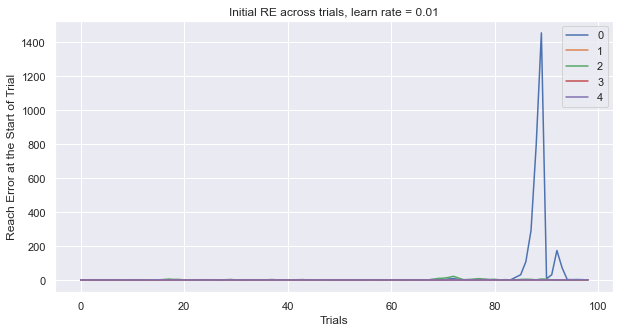

In [16]:
NUM_TRIALS = 100
NUM_RUNS = 2 # Has to be >1 # 2 = goes through the trial for target once
NUM_SESSIONS = 5
# rate_list = [5e-3, 1e-3, 5e-4, 1e-4]
rate_list = [1e-2]
A_RATE = 5e-5
K_RATE = 5e-5
ADAPT_TRIALS = NUM_TRIALS

# initialization
cursor_start = np.zeros( (NUM_DIM, 1, NUM_TRIALS, NUM_SESSIONS) )
cursor_end = np.zeros( (NUM_DIM, 1, NUM_TRIALS, NUM_SESSIONS) )
target_trial = np.zeros( (NUM_DIM, 1, NUM_TRIALS, NUM_SESSIONS) )
lambda_trial = np.zeros( (NUM_NEURONS, NUM_LAMBDA, NUM_TRIALS, NUM_SESSIONS) )
fr_trial = np.zeros( (NUM_NEURONS, 1, NUM_TRIALS) )
a_trial = np.zeros( (NUM_DIM, NUM_TRIALS, NUM_SESSIONS) )
k_trial = np.zeros( (NUM_DIM, NUM_NEURONS, NUM_TRIALS, NUM_SESSIONS) )
re_startT = np.zeros( (NUM_TRIALS, NUM_SESSIONS) )
re_endT = np.zeros( (NUM_TRIALS, NUM_SESSIONS) )


for lambda_rate in rate_list:
    for iS in range(NUM_SESSIONS):
        print("")
        print("+++++++++++++++++++++++++++++++++++")
        print("Session #" + str(iS))
        ## BRAIN SIDE
        FR_DIST = (FR_SIGMA, FR_DELTA, FR_DIST_SIZE)
    #     fr_init[:, 0] = np.array(brainFiringRate(lambda_init, TARGET_VECTOR_ERR))

        ## DECODER SIDE
        A_DIST = (A_SIGMA, A_DELTA, A_DIST_SIZE)
        K_DIST = (K_SIGMA, K_DELTA, K_DIST_SIZE)

        # target position -- new target represents a new trial
        target_trial[:, :, 0, iS] = TARGET_VECTOR
        print("target at trial 0 = " + str(target_trial[:, :, 0, iS]))

        print("K MATX INIT= " + str(K_MATX))
        print("A VECT INIT = " + str(A_VECT))

        ## VECTORS FOR TRIALS    
        lambda_trial[:, :, 0, iS] = lambda_init
        print("lambda")
        print(lambda_trial[:, :, 0, iS])

        a_trial[:, 0, iS] = np.array(A_VECT)
        print("a")
        print(a_trial[:, 0, iS])

        k_trial[:,:, 0, iS] = K_MATX
        print("K")
        print(k_trial[:,:, 0, iS] )
        decoder_params = (a_trial[:, 0, iS], A_RATE, A_DIST, k_trial[:,:,  0, iS], K_RATE, K_DIST)
        decoder_vals = (A_VECT, K_MATX)
        

        for iT in range(NUM_TRIALS-1):
            print("")
            print("=========================================")
            print("Trial #" + str(iT) + " | lambda learn rate = " + str(lambda_rate))
            print("Target = " + str(target_trial[:, :, iT, iS]))

            # calculate firing rate given lambda and decoder parameters with current target position 
            fr_start = np.array(brainFiringRate(lambda_trial[:, :, iT, iS], target_trial[:, :, iT, iS]))
            fr_trial[:, :, iT] = fr_start
            
            print("lambda start of trial = " + str(lambda_trial[:, :, iT, iS]))
            # calculate reach error of firing rate at the beginning of the trial
            # this becomes the error of the new target position being presented and where the cursor is
            brain_vars = ( fr_trial[:, :, iT],  target_trial[:, :, iT, iS] )
            cost_func_params = (decoder_vals, brain_vars) 
            
            re_startT[iT, iS] = error_costFunc(cost_func_params)

    #         (a_vect_in, k_matx_in) = decoder_params
            cursor_start[ :, :, iT, iS] =  (decoder_findY(decoder_vals, brain_vars))
            print("cursor start = " + str(cursor_start[:, :, iT, iS]) )
            print("decoder vals start = " + str(decoder_vals))

            # Run through trial and see the reach at the end        
            # current brain and decoder params
            brain_params = (fr_trial[:, :, iT], FR_DIST, lambda_trial[:, :, iT, iS], lambda_rate)
            decoder_params = (a_trial[:, iT, iS], A_RATE, A_DIST, k_trial[:, :,  iT, iS], K_RATE, K_DIST)

            # adapt brain and decoder (together here)
            a_run, k_run = calcNextDecoder(decoder_params, brain_vars)
            if (KW_only):
                a_run = np.zeros((2, 1))
            fr_run, lambda_run = calcNextBrain(brain_params, decoder_params, target_trial[:, :, iT, iS], NUM_RUNS)
            
    #         print("fr_run = " + str(fr_run))
#             re_run, fr_run, lambda_run = brain_adapt_sgd(brain_params, decoder_params, target_trial[:, :, iT], NUM_RUNS)
            # update cost function arguments
            decoder_vals = (a_run, k_run)
            brain_vars = (fr_run, target_trial[:, :, iT, iS])
            # see how the updated decoder and brain paramters have done with the current
            # target position (so target at trial = iT)
            cost_func_params = (decoder_vals, brain_vars) 
            re_run = np.array(error_costFunc(cost_func_params))

            # So what are the end trial metrics?
            if (KW_only):
                lambda_run[:, 0] = 0
            cursor_end[:, :, iT, iS] =  (decoder_findY(decoder_vals, brain_vars))
#             print("fr end of trial = " + str(fr_run))
            print("lambda end of trial = " + str(lambda_run))
            print("cursor end = " + str(cursor_end[:, :, iT, iS]) )

            re_endT[iT, iS] = re_run
#             print("re end = " + str(re_endT[iT, iS]))
#             print("re diff = " + str(re_endT[iT, iS] - re_startT[iT, iS]))

            # update the parameters
            lambda_trial[:, :, iT + 1, iS] = np.squeeze(lambda_run)
            a_trial[:, iT + 1, iS] = np.squeeze(a_run)
            k_trial[:, :, iT + 1, iS] = np.squeeze(k_run)
            print("a = " + str(a_trial[:, iT + 1, iS]))
            print("k = " + str(k_trial[:, :, iT + 1, iS]))

            # change to new target
            target_trial[:, 0, iT + 1, iS] = findNextTarget( cursor_end[:, :, iT, iS], target_trial[:, :, iT, iS] )
    
        
        pidx = rate_list.index(lambda_rate)
        plt.figure(2*pidx + 1, figsize=(fig_x, fig_y))
        plt.plot(np.arange(0, NUM_TRIALS-1, 1), re_startT[0:len(re_startT)-1, iS], label = '' + str(iS))
        plt.legend()
        plt.xlabel('Trials')
        plt.ylabel('Reach Error at the Start of Trial')
        plt.title('Initial RE across trials, learn rate = ' + str(lambda_rate))

    

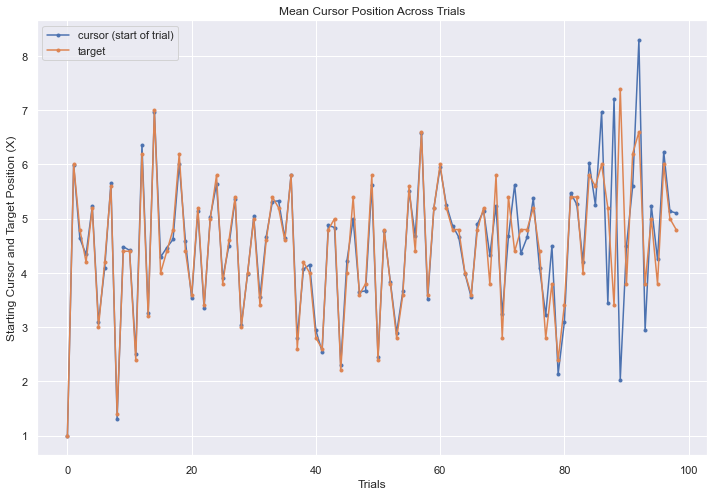

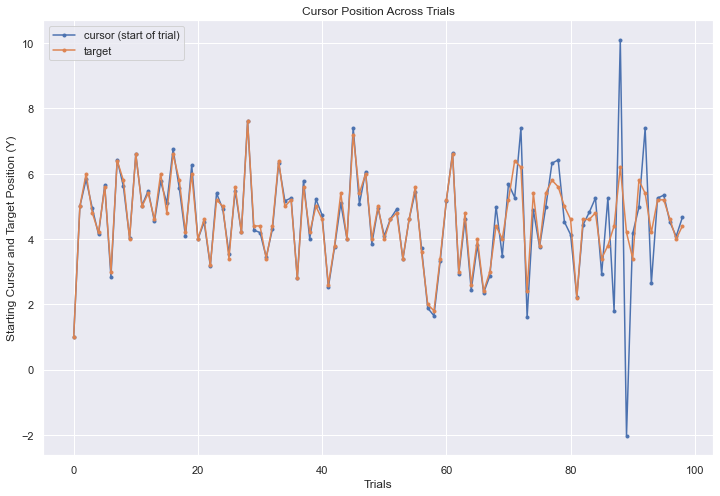

In [17]:
x = 0
y = 1

plt.figure(figsize = (12, 8))
start_x_mean = np.mean(cursor_start, axis=3)[x, 0, 0:NUM_TRIALS-1]
end_x_mean = np.mean(cursor_end, axis=3)[x, 0, 0:NUM_TRIALS-1]
start_y_mean = np.mean(cursor_start, axis=3)[y, 0, 0:NUM_TRIALS-1]
end_y_mean = np.mean(cursor_end, axis=3)[y, 0, 0:NUM_TRIALS-1]
targ_x_mean = np.mean(target_trial, axis=3)[x, 0, 0:NUM_TRIALS-1]
targ_y_mean = np.mean(target_trial, axis=3)[y, 0, 0:NUM_TRIALS-1]

plt.plot(start_x_mean, linestyle = '-', marker = '.', label = 'cursor (start of trial)')
plt.plot(targ_x_mean, linestyle = '-', marker = '.', label = 'target' )
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Starting Cursor and Target Position (X)')
plt.title('Mean Cursor Position Across Trials')
plt.show()

# plt.figure(figsize = (12, 8))
# plt.plot(np.arange(0, NUM_TRIALS, 1), end_x_mean, linestyle = '-', marker = '.', label = 'cursor (end of trial)')
# plt.plot(np.arange(0, NUM_TRIALS, 1), targ_x_mean, linestyle = '-', marker = '.', label = 'target' )
# plt.legend()
# plt.xlabel('Trials')
# plt.ylabel('Ending Cursor and Target Position (X)')
# plt.title('Cursor Position Across Trials')
# plt.show()

plt.figure(figsize = (12, 8))
plt.plot(start_y_mean, linestyle = '-', marker = '.', label = 'cursor (start of trial)')
plt.plot(targ_y_mean, linestyle = '-', marker = '.', label = 'target' )
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Starting Cursor and Target Position (Y)')
plt.title('Cursor Position Across Trials')
plt.show()

# plt.figure(figsize = (12, 8))
# plt.plot(np.arange(0, NUM_TRIALS, 1), end_y_mean, linestyle = '-', marker = '.', label = 'cursor (end of trial)')
# plt.plot(np.arange(0, NUM_TRIALS, 1), targ_y_mean, linestyle = '-', marker = '.', label = 'target' )
# plt.legend()
# plt.xlabel('Trials')
# plt.ylabel('Ending Cursor and Target Position (Y)')
# plt.title('Cursor Position Across Trials')
# plt.show()

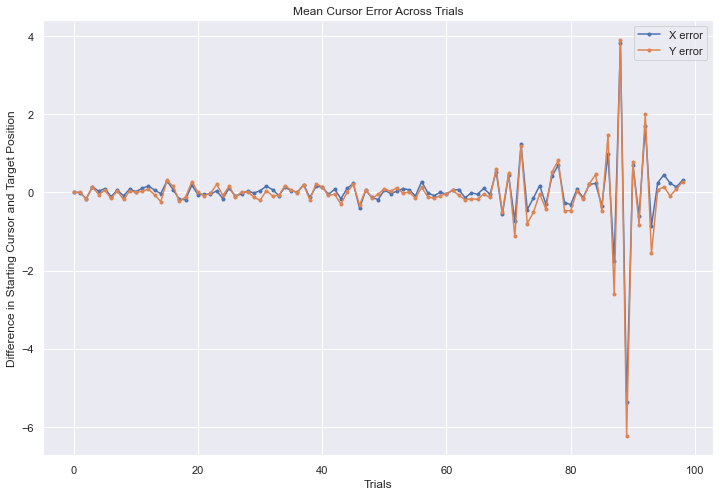

In [18]:
plt.figure(figsize = (12, 8))
plt.plot(start_x_mean - targ_x_mean, linestyle = '-', marker = '.', label = 'X error')
plt.plot(start_y_mean - targ_y_mean, linestyle = '-', marker = '.', label = 'Y error' )
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Difference in Starting Cursor and Target Position')
plt.title('Mean Cursor Error Across Trials')
plt.show()

Text(0.5, 1.0, 'Mean KW Matrix (1,1)')

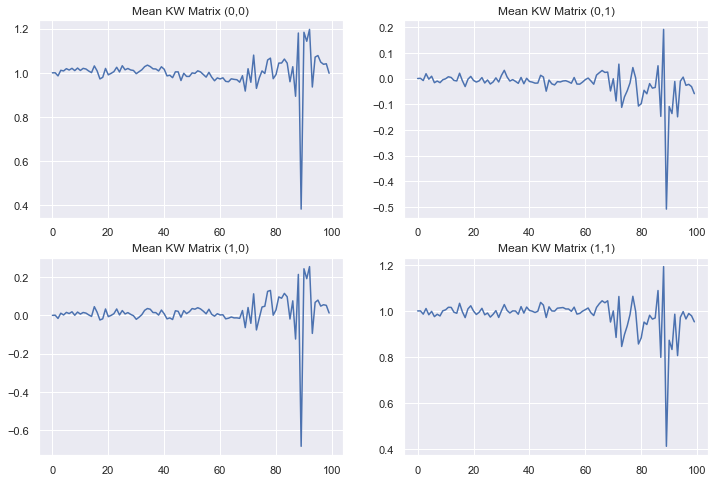

In [19]:
# print(np.shape(lambda_trial))
# print(np.shape(k_trial))
# print(np.shape((k_trial[:, :,1])))
# print(np.shape((lambda_trial[:, 1:3, 1])))

lk_mtx = np.zeros((NUM_DIM, NUM_DIM, NUM_TRIALS))
lk_mtx_temp = np.zeros((NUM_DIM, NUM_DIM, NUM_TRIALS, NUM_SESSIONS))
# print(np.shape((k_trial[:,:, :, 1])))
# print((lambda_trial[:, 1:3, 1, 1]))
for iT in range(NUM_TRIALS):
    for iS in range(NUM_SESSIONS):
        lk_mtx_temp[:,:, iT, iS] = np.matmul(k_trial[:,:, iT, iS], lambda_trial[:, 1:3, iT, iS])
    lk_mtx = np.mean(lk_mtx_temp[:,:, :, :], axis=3)

 
plt.figure(figsize = (12, 8))
plt.subplot(221)
plt.plot(lk_mtx[0, 0, :])
plt.title("Mean KW Matrix (0,0)")

plt.subplot(222)
plt.plot(lk_mtx[0, 1, :])
plt.title("Mean KW Matrix (0,1)")

plt.subplot(223)
plt.plot(lk_mtx[1, 0, :])
plt.title("Mean KW Matrix (1,0)")

plt.subplot(224)
plt.plot(lk_mtx[1, 1, :])
plt.title("Mean KW Matrix (1,1)")


Text(0.5, 1.0, 'Mean KW Matrix (1,1) | Last 100 Trials ')

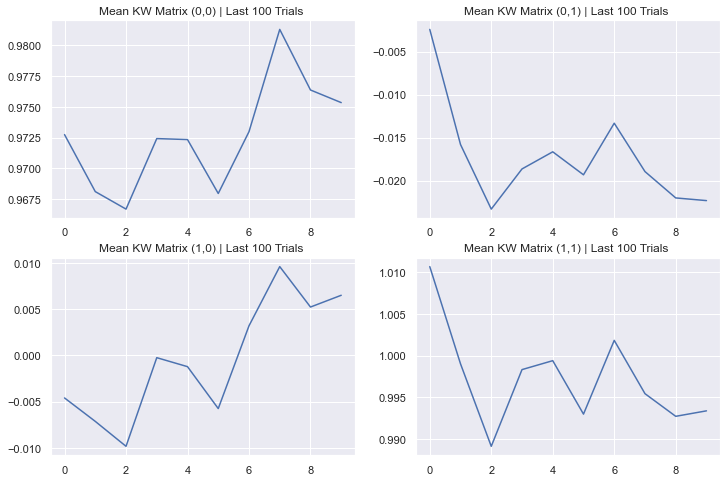

In [14]:
last = 10

plt.figure(figsize = (12, 8))
plt.subplot(221)
plt.plot(lk_mtx[0, 0, NUM_TRIALS-1-last:NUM_TRIALS-1])
plt.title("Mean KW Matrix (0,0) | Last 100 Trials ")

plt.subplot(222)
plt.plot(lk_mtx[0, 1,  NUM_TRIALS-1-last:NUM_TRIALS-1])
plt.title("Mean KW Matrix (0,1) | Last 100 Trials ")


plt.subplot(223)
plt.plot(lk_mtx[1, 0,  NUM_TRIALS-1-last:NUM_TRIALS-1])
plt.title("Mean KW Matrix (1,0) | Last 100 Trials ")

plt.subplot(224)
plt.plot(lk_mtx[1, 1,  NUM_TRIALS-1-last:NUM_TRIALS-1])
plt.title("Mean KW Matrix (1,1) | Last 100 Trials ")


In [15]:
print("Average Reach Error Per Session:")

for iS in range(NUM_SESSIONS):
    print("Session # " + str(iS) + "| RE = " + str(np.mean(re_startT[:, iS])))

Average Reach Error Per Session:
Session # 0| RE = 0.044738649033562776
Session # 1| RE = 0.048016879514629296
Session # 2| RE = 0.07873963505577178
Session # 3| RE = 0.08819744779091283
Session # 4| RE = 0.06486180089583594
